Import Necessary Libraries

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import geopandas as gpd
from tqdm import tqdm
import rasterio
import seaborn as sns

# ETL (Extract, Transform, Load)

## Load and explore the dataset

### Geothermal Gradients Dataset

In [3]:
gradients = pd.read_excel('data/Anexo 1. GRADIENTES GEOTÉRMICOS APARENTES.xlsx',sheet_name=1)
gradients = gradients.rename(columns={"Longitud": "Lon", "Latitud": "Lat"})
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),Elevacion \n(m),Temperatura en superficie \n(°C),BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,313.9440,26.630280,100.0,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,313.3344,26.633328,110.0,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,316.3824,26.618088,113.0,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,275.2344,26.823828,200.0,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,90.5256,27.747372,159.0,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0


### Moho Depth Dataset

In [4]:
moho_depth = pd.read_csv('data/south-american-moho.txt', delim_whitespace=True, comment="#", header=None, names=["Latitude", "Longitude", "Moho Depth (m)"])
moho_depth = moho_depth.rename(columns={"Longitude": "Lon", "Latitude": "Lat"})
moho_depth.head()

,Lat,Lon,Moho Depth (m)
0,-60.0,270.0,32674.89851
1,-60.0,270.4,26702.16351
2,-60.0,270.8,23617.60412
3,-60.0,271.2,22474.44981
4,-60.0,271.6,22003.43619


### LAB depth dataset

In [5]:
file_path = 'data/LithoRef18.xyz'

lab_depth = pd.read_table(file_path, delim_whitespace=True, header=None, names=[
    'LONG', 'LAT', 'ELEVATION', 'MOHO', 'LAB', 'RHO_C', 'RHO_L', 'RHO_SL',
    'BOTTOM', 'GEOID', 'FA', 'G_zz', 'G_xx', 'G_yy'
], skiprows=9)
lab_depth = lab_depth.rename(columns={"LONG": "Lon", "LAT": "Lat"})

lab_depth

,Lon,Lat,ELEVATION,MOHO,LAB,RHO_C,RHO_L,RHO_SL,BOTTOM,GEOID,FA,G_zz,G_xx,G_yy
0,-179.0,-89.0,2965.0,-38880.18,-120036.38,2850.92,3329.86,3437.13,-410000.0,-0.81,0.82,0.01,0.04,-0.12
1,-179.0,-87.0,2915.0,-38880.18,-120036.38,2850.92,3329.86,3437.13,-410000.0,5.01,38.25,0.33,-0.10,-0.23
2,-179.0,-85.0,1680.0,-40068.56,-61717.27,2754.42,3274.83,3445.69,-410000.0,4.78,36.06,0.22,-0.10,-0.12
3,-179.0,-83.0,17.5,-27384.31,-49505.28,2789.22,3270.61,3431.93,-410000.0,0.15,-17.35,-0.08,-0.02,0.10
4,-179.0,-81.0,-2.5,-28174.61,-34705.37,2755.78,3247.06,3429.78,-410000.0,0.81,-0.02,-0.06,-0.00,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,179.0,81.0,-1960.0,-16517.33,-97953.06,2686.46,3322.25,3442.41,-410000.0,2.76,8.78,-0.00,-0.10,0.09
16196,179.0,83.0,-2467.5,-19075.27,-108049.57,2783.24,3335.58,3444.81,-410000.0,3.28,6.77,0.07,-0.12,0.05
16197,179.0,85.0,-2422.5,-17274.34,-121981.55,2740.28,3348.45,3443.39,-410000.0,3.42,13.84,0.12,-0.10,-0.02
16198,179.0,87.0,-3822.5,-14569.69,-124492.00,2806.42,3350.09,3443.20,-410000.0,1.52,3.85,0.04,-0.06,0.02


### Volcanos

In [6]:
volcanos = pd.read_csv('data/Volcanes_col.csv')
volcanos = volcanos.rename(columns={"X": "Lon", "Y": "Lat"})
volcanos.head()

,Lon,Lat,OBJECTID,VolcanID,NombreVolcan,AlturaSobreNivelMar,Latitud,Longitud,Comentarios,URL,GlobalID
0,-76.214977,1.916518,1,NaN,NaN,1800.0,"1° 54' 59,465"" N","76° 12' 53,917"" W",Edificio volcánico en el municipio de Isnos en...,NaN,071b82b6-5b8a-47d0-ba87-5ebfd34e4bac
1,-76.166495,2.232286,2,NaN,Volcan Santa Leticia,NaN,"2° 13' 56,229"" N","76° 9' 59,382"" W",NaN,NaN,f5a4cc3d-fc7e-46a1-b8d9-69fdcb4a541a
2,-76.082576,2.179546,3,NaN,Volcán El Pensil,2200.0,"2° 10' 46,366"" N","76° 4' 57,273"" W",NaN,NaN,e09ff266-bee3-4ea4-98df-8765b2c0b164
3,-76.217778,2.110280,4,NaN,Volcán El Dorado,2000.0,"2° 6' 37,008"" N","76° 13' 4,001"" W",NaN,NaN,073bdc7f-d632-4954-a383-cc1d4d083b7c
4,-76.477694,2.240949,5,NaN,Maar de Yerbabuena,3100.0,"2° 14' 27,415"" N","76° 28' 39,697"" W",NaN,NaN,d6077acc-cac2-4c9b-be59-64ba98040e8a


## Data Preprocessing

### Moho Depth

We need to convert the Longitude from 0, 360° to -180°, 180°

In [7]:
moho_depth["Lon"] = moho_depth["Lon"].apply(lambda x: x - 360 if x > 180 else x)

moho_depth.head()

,Lat,Lon,Moho Depth (m)
0,-60.0,-90.0,32674.89851
1,-60.0,-89.6,26702.16351
2,-60.0,-89.2,23617.60412
3,-60.0,-88.8,22474.44981
4,-60.0,-88.4,22003.43619


Crop the moho_depth dataset so that it fits within the spatial extent of the first dataset (geothermal gradient).

In [8]:
# Define the spatial extent boundaries from the "gradients" dataset
min_lon, max_lon = -79, -66
min_lat, max_lat = -4, 13

# Crop the "moho_depth" dataset to fit within the spatial extent of the "gradients" dataset
moho_depth= moho_depth[
    (moho_depth["Lat"] >= min_lat) & (moho_depth["Lat"] <= max_lat) &
    (moho_depth["Lon"] >= min_lon) & (moho_depth["Lon"] <= max_lon)
]

moho_depth.head()

,Lat,Lon,Moho Depth (m)
21168,-4.0,-78.8,45859.19310
21169,-4.0,-78.4,41519.99589
21170,-4.0,-78.0,37978.25522
21171,-4.0,-77.6,35067.20699
21172,-4.0,-77.2,33574.10409


In [9]:
missing_values = moho_depth.isnull().sum()
missing_values

Lat               0
Lon               0
Moho Depth (m)    0
dtype: int64

### LAB depth

In [10]:
min_lon, max_lon = -79, -66
min_lat, max_lat = -4, 13

# Crop the "lab_depth" dataset to fit within the spatial extent of the "gradients" dataset
lab_depth = lab_depth[
    (lab_depth["Lat"] >= min_lat) & (lab_depth["Lat"] <= max_lat) &
    (lab_depth["Lon"] >= min_lon) & (lab_depth["Lon"] <= max_lon)
]

# Use .loc to modify the 'LAB' column without triggering the warning
lab_depth.loc[:, "LAB"] = lab_depth["LAB"].abs()
lab_depth.head()

,Lon,Lat,ELEVATION,MOHO,LAB,RHO_C,RHO_L,RHO_SL,BOTTOM,GEOID,FA,G_zz,G_xx,G_yy
4543,-79.0,-3.0,1665.0,-37602.51,160215.66,2833.56,3347.73,3459.92,-410000.0,1.96,48.19,0.26,-0.40,0.14
4544,-79.0,-1.0,1727.5,-42014.98,94948.53,2864.77,3307.51,3445.00,-410000.0,6.22,73.47,0.62,-0.40,-0.22
4545,-79.0,1.0,375.0,-32379.28,69123.74,2863.25,3289.11,3434.99,-410000.0,3.09,22.20,0.45,-0.24,-0.21
4546,-79.0,3.0,-2040.0,-19443.30,99015.53,2824.72,3333.46,3440.63,-410000.0,-1.95,-31.88,0.04,-0.01,-0.03
4547,-79.0,5.0,-3160.0,-15588.41,81981.18,2883.67,3307.60,3436.79,-410000.0,1.19,4.13,0.11,0.02,-0.12


In [11]:
lab_depth.columns

Index(['Lon', 'Lat', 'ELEVATION', 'MOHO', 'LAB', 'RHO_C', 'RHO_L', 'RHO_SL',
       'BOTTOM', 'GEOID', 'FA', 'G_zz', 'G_xx', 'G_yy'],
      dtype='object')

### Gradients

In [12]:
# Check for missing values
missing_values = gradients.isnull().sum()
missing_values

UWI                                       32
Nombre del Pozo                           30
Profundidad Total \n(ft)                  33
Departamento                              38
Cuenca                                    38
Lat                                      100
Lon                                      100
Coordenada\nX                             38
Coordenada \n Y                           38
Elevación GL\n(ft)                       444
Elevacion \n(m)                           38
Temperatura en superficie \n(°C)          38
BHT\n(°F)                                 38
BHT\n(°C)                                 38
Profundidad BHT\n(ft)                     38
Profundidad BHT \n(m)                     38
Temperatura de formación (°C)             38
Gradiente Geotérmico Aparente (°C/Km)     38
Año de actualizacion del dato             38
dtype: int64

Remove rows without geothermal gradient, latitude or longitude values

In [13]:
gradients = gradients.dropna(subset=["Gradiente Geotérmico Aparente (°C/Km)"])
gradients = gradients.dropna(subset=["Lat", "Lon"])

gradients.tail()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),Elevacion \n(m),Temperatura en superficie \n(°C),BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato
4600,ZENO0001,ZENON-1,6422,Bolivar,Valle Inferior del Magdalena,9.198753,-74.545831,9.489047e+05,1.508724e+06,49.0,14.9352,28.125324,152.0,66.666667,6423.0,1957.7304,72.962956,22.902864,2008.0
4601,ZENO0002,ZENON-2,6196,Bolivar,Valle Inferior del Magdalena,9.193783,-74.545203,9.489730e+05,1.508175e+06,58.0,17.6784,28.111608,152.0,66.666667,6196.0,1888.5408,72.679641,23.599190,2008.0
4602,ZENO0003,ZENON-3,6559,Magdalena,Valle Inferior del Magdalena,9.210378,-74.266786,9.795733e+05,1.509982e+06,70.0,21.3360,28.093320,152.0,66.666667,6559.0,1999.1832,73.133462,22.529272,2008.0
4603,ZULI0001W,ZULIA WEST-1,7655,Norte de Santander,Catatumbo,8.213381,-72.470731,1.177448e+06,1.400064e+06,285.0,86.8680,27.765660,166.0,74.444444,7765.0,2366.7720,82.434751,23.098588,2008.0
4604,ZULI0001E,ZULIA-1 EAST,3361.5,Norte de Santander,Catatumbo,8.202650,-72.439292,1.180919e+06,1.398891e+06,NaN,114.0000,27.630000,112.0,44.444444,3410.0,1039.3680,47.235248,18.862662,2008.0


In [14]:
missing_values = gradients.isnull().sum()
missing_values

UWI                                        0
Nombre del Pozo                            0
Profundidad Total \n(ft)                   0
Departamento                               0
Cuenca                                     0
Lat                                        0
Lon                                        0
Coordenada\nX                              0
Coordenada \n Y                            0
Elevación GL\n(ft)                       348
Elevacion \n(m)                            0
Temperatura en superficie \n(°C)           0
BHT\n(°F)                                  0
BHT\n(°C)                                  0
Profundidad BHT\n(ft)                      0
Profundidad BHT \n(m)                      0
Temperatura de formación (°C)              0
Gradiente Geotérmico Aparente (°C/Km)      0
Año de actualizacion del dato              0
dtype: int64

In [15]:
for col in gradients.columns:
    print(col)

UWI
Nombre del Pozo
Profundidad Total 
(ft)
Departamento
Cuenca
Lat
Lon
Coordenada
X
Coordenada 
 Y
Elevación GL
(ft)
Elevacion 
(m)
Temperatura en superficie 
(°C)
BHT
(°F)
BHT
(°C)
Profundidad BHT
(ft)
Profundidad BHT 
(m)
Temperatura de formación (°C)
Gradiente Geotérmico Aparente (°C/Km)
Año de actualizacion del dato


### Volcanos

In [16]:
missing_values = volcanos.isnull().sum()
missing_values

Lon                     0
Lat                     0
OBJECTID                0
VolcanID               61
NombreVolcan           14
AlturaSobreNivelMar     4
Latitud                 0
Longitud                0
Comentarios            54
URL                    41
GlobalID                0
dtype: int64

There's not much to do with volcanos dataset as they don't have missing Lon and Lat values.

## Feature Engineering

### Distance to nearest volcano

In [17]:
import geopandas as gpd
from shapely.geometry import Point
import math

In [18]:
# Load the "gradients" and "volcanos" datasets into GeoDataFrames
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
volcanos_gdf = gpd.GeoDataFrame(volcanos, geometry=gpd.points_from_xy(volcanos['Lon'], volcanos['Lat']))

# Initialize an empty list to store distances to the nearest volcano (in meters)
distances_to_nearest_volcano = []

# Radius of the Earth in meters
earth_radius = 6371000  # Approximately

# Iterate through each well
for well in gradients_gdf.itertuples():
    nearest_volcano_distance = float('inf')  # Initialize with a large value
    
    # Iterate through each volcano to find the nearest one
    for volcano in volcanos_gdf.itertuples():
        # Haversine formula to calculate the great-circle distance
        lon1, lat1 = well.geometry.x, well.geometry.y
        lon2, lat2 = volcano.geometry.x, volcano.geometry.y

        dlon = math.radians(lon2 - lon1)
        dlat = math.radians(lat2 - lat1)

        a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        distance = earth_radius * c
        nearest_volcano_distance = min(nearest_volcano_distance, distance)
    
    distances_to_nearest_volcano.append(nearest_volcano_distance)

# Add the distances to the "gradients" dataset as a new column (in meters)
gradients['Distance_To_Nearest_Volcano (m)'] = distances_to_nearest_volcano

In [19]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),Elevacion \n(m),Temperatura en superficie \n(°C),BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato,Distance_To_Nearest_Volcano (m)
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,313.9440,26.630280,100.0,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0,37601.741109
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,313.3344,26.633328,110.0,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0,37852.172379
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,316.3824,26.618088,113.0,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0,37716.838356
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,275.2344,26.823828,200.0,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0,74806.593793
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,90.5256,27.747372,159.0,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0,84902.242439


### Volcanoes nearby (within radius = nearest volcano + 5 Km)

In [20]:
import geopy.distance

# The radius is the distance to the nearest volcano plus 5000 meters (5 kilometers)
gradients['Radius (m)'] = gradients['Distance_To_Nearest_Volcano (m)'] + 5000

# Initialize an empty list to store the counts of nearby volcanoes
num_volcanoes_nearby = []

# Iterate through each well to count nearby volcanoes
for index, row in gradients.iterrows():
    well_location = (row['Lat'], row['Lon'])
    radius = row['Radius (m)']
    
    # Calculate the number of volcanoes within the specified radius
    num_nearby_volcanoes = len(volcanos[
        volcanos.apply(lambda x: geopy.distance.distance(well_location, (x['Lat'], x['Lon'])).m <= radius, axis=1)
    ])
    
    num_volcanoes_nearby.append(num_nearby_volcanoes)

# Add the "Number of Volcanoes Nearby" feature to the "gradients" dataset
gradients['Number of Volcanoes Nearby'] = num_volcanoes_nearby

# Verify the updated dataset
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),...,BHT\n(°F),BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato,Distance_To_Nearest_Volcano (m),Radius (m),Number of Volcanoes Nearby
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,...,100.0,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0,37601.741109,42601.741109,2
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,...,110.0,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0,37852.172379,42852.172379,2
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,...,113.0,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0,37716.838356,42716.838356,2
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,...,200.0,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0,74806.593793,79806.593793,5
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,...,159.0,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0,84902.242439,89902.242439,5


### Moho Depth

In [21]:
from scipy.interpolate import griddata

# Load the "gradients" and "moho_depth" datasets into GeoDataFrames
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
moho_depth_gdf = gpd.GeoDataFrame(moho_depth, geometry=gpd.points_from_xy(moho_depth['Lon'], moho_depth['Lat']))

# Convert GeoDataFrames to numpy arrays
gradients_array = gradients_gdf[['Lon', 'Lat']].values
moho_depth_array = moho_depth_gdf[['Lon', 'Lat', 'Moho Depth (m)']].values

# Separate the coordinates and values
coordinates, values = moho_depth_array[:, :2], moho_depth_array[:, 2]

# Initialize tqdm for progress bar
pbar = tqdm(total=len(gradients_array), desc="Interpolating", ncols=100)

# Initialize an empty list to store interpolated Moho depth values for each well
moho_depth_values = []

# Iterate through each well
for gradient in gradients_array:
    # Use griddata for interpolation
    moho_depth_value = griddata(coordinates, values, [gradient], method='cubic')
    
    # Append the interpolated Moho depth value to the list
    moho_depth_values.append(moho_depth_value[0])
    
    # Update the progress bar
    pbar.update()

# Close the progress bar
pbar.close()

# Add the interpolated Moho depth values to the "gradients" dataset as a new column
gradients['Moho_Depth (m)'] = moho_depth_values

Interpolating:   0%|                                                       | 0/4543 [00:00<?, ?it/s]

Interpolating: 100%|████████████████████████████████████████████| 4543/4543 [01:11<00:00, 63.33it/s]


In [22]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),...,BHT\n(°C),Profundidad BHT\n(ft),Profundidad BHT \n(m),Temperatura de formación (°C),Gradiente Geotérmico Aparente (°C/Km),Año de actualizacion del dato,Distance_To_Nearest_Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho_Depth (m)
0,ABAN0004,ABANICO-4,3020,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,...,37.777778,3020.0,920.4960,40.172876,14.712281,2008.0,37601.741109,42601.741109,2,42863.912006
1,ABAN0005,ABANICO-5,2928,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,...,43.333333,2928.0,892.4544,45.637603,21.294394,2008.0,37852.172379,42852.172379,2,42855.311332
2,ABAN0006,ABANICO-6,2904,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,...,45.000000,2842.0,866.2416,47.220262,23.783404,2008.0,37716.838356,42716.838356,2,42859.265493
3,ACAE0001,ACAE-1,10578,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,...,93.333333,10573.0,3222.6504,104.671211,24.156323,2008.0,74806.593793,79806.593793,5,36310.810774
4,ACAE0010,ACAE-10,10757,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,...,70.555556,6268.0,1910.4864,76.658202,25.601245,2008.0,84902.242439,89902.242439,5,37832.879615


### LAB Depth and geophysical data

In [23]:
from scipy.interpolate import griddata

# Create GeoDataFrames from datasets
gradients_gdf = gpd.GeoDataFrame(gradients, geometry=gpd.points_from_xy(gradients['Lon'], gradients['Lat']))
lab_depth_gdf = gpd.GeoDataFrame(lab_depth, geometry=gpd.points_from_xy(lab_depth['Lon'], lab_depth['Lat']))

# Define the grid points for interpolation
grid_x = gradients_gdf['Lon']
grid_y = gradients_gdf['Lat']

# Define the columns to interpolate
columns_to_interpolate = ['LAB', 'RHO_C', 'RHO_L', 'RHO_SL', 'FA', 'G_zz', 'G_xx', 'G_yy']

# Initialize an empty DataFrame to store interpolated values
interpolated_values = pd.DataFrame(index=gradients_gdf.index)

# Iterate through each column to interpolate
for column in columns_to_interpolate:
    interpolated_column = griddata(
        (lab_depth_gdf['Lon'], lab_depth_gdf['Lat']),
        lab_depth_gdf[column],
        (grid_x, grid_y),
        method='cubic'
    )
    interpolated_values[column] = interpolated_column

# Add the interpolated values to the "gradients" DataFrame
gradients = pd.concat([gradients, interpolated_values], axis=1)

In [24]:
gradients.to_csv('gradients_no_mag.csv', index=False)

In [25]:
gradients = pd.read_csv('gradients_no_mag.csv')

In [26]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),...,Number of Volcanoes Nearby,Moho_Depth (m),LAB,RHO_C,RHO_L,RHO_SL,FA,G_zz,G_xx,G_yy
0,ABAN0004,ABANICO-4,3020.0,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,...,2,42863.912006,180982.196974,2908.355573,3351.741757,3471.512630,52.850111,0.980896,-0.571805,-0.409557
1,ABAN0005,ABANICO-5,2928.0,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,...,2,42855.311332,181091.851707,2908.222541,3351.727744,3471.560022,52.815770,0.980755,-0.571548,-0.409674
2,ABAN0006,ABANICO-6,2904.0,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,...,2,42859.265493,181040.260260,2908.280522,3351.734070,3471.537395,52.833159,0.980844,-0.571682,-0.409628
3,ACAE0001,ACAE-1,10578.0,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,...,5,36310.810774,67583.917945,2835.980674,3282.586490,3441.440446,35.824963,0.635515,-0.359978,-0.269995
4,ACAE0010,ACAE-10,10757.0,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,...,5,37832.879615,60788.349259,2840.500170,3278.407951,3438.858531,27.407060,0.586203,-0.318344,-0.262304


### Magnetic anomaly

In [27]:
src = rasterio.open('data/Mag_anom_col.tif')

# Print the CRS
print(src.crs)

EPSG:4326


In [28]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/Mag_anom_col.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
gradients['Magnetic Anomaly (nT)'] = gradients.apply(lambda row: get_value_from_tiff(row['Lat'], row['Lon']), axis=1)

In [29]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total \n(ft),Departamento,Cuenca,Lat,Lon,Coordenada\nX,Coordenada \n Y,Elevación GL\n(ft),...,Moho_Depth (m),LAB,RHO_C,RHO_L,RHO_SL,FA,G_zz,G_xx,G_yy,Magnetic Anomaly (nT)
0,ABAN0004,ABANICO-4,3020.0,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,...,42863.912006,180982.196974,2908.355573,3351.741757,3471.512630,52.850111,0.980896,-0.571805,-0.409557,-43.682499
1,ABAN0005,ABANICO-5,2928.0,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,...,42855.311332,181091.851707,2908.222541,3351.727744,3471.560022,52.815770,0.980755,-0.571548,-0.409674,-43.682499
2,ABAN0006,ABANICO-6,2904.0,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,...,42859.265493,181040.260260,2908.280522,3351.734070,3471.537395,52.833159,0.980844,-0.571682,-0.409628,-43.682499
3,ACAE0001,ACAE-1,10578.0,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,...,36310.810774,67583.917945,2835.980674,3282.586490,3441.440446,35.824963,0.635515,-0.359978,-0.269995,-3.928700
4,ACAE0010,ACAE-10,10757.0,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,...,37832.879615,60788.349259,2840.500170,3278.407951,3438.858531,27.407060,0.586203,-0.318344,-0.262304,-2.242400


## Dataset cleaning

In [30]:
# Replace "\n" with a space in column names
gradients.columns = gradients.columns.str.replace('\n', ' ')

In [31]:
gradients.columns = gradients.columns.str.replace('  ', ' ')
gradients.columns = gradients.columns.str.replace('   ', ' ')

In [32]:
gradients.head()

,UWI,Nombre del Pozo,Profundidad Total (ft),Departamento,Cuenca,Lat,Lon,Coordenada X,Coordenada Y,Elevación GL (ft),...,Moho_Depth (m),LAB,RHO_C,RHO_L,RHO_SL,FA,G_zz,G_xx,G_yy,Magnetic Anomaly (nT)
0,ABAN0004,ABANICO-4,3020.0,Tolima,Valle Superior del Magdalena,4.213002,-74.893581,909770.865223,957357.370043,1030.0,...,42863.912006,180982.196974,2908.355573,3351.741757,3471.512630,52.850111,0.980896,-0.571805,-0.409557,-43.682499
1,ABAN0005,ABANICO-5,2928.0,Tolima,Valle Superior del Magdalena,4.216078,-74.888898,910291.244350,957696.956787,1028.0,...,42855.311332,181091.851707,2908.222541,3351.727744,3471.560022,52.815770,0.980755,-0.571548,-0.409674,-43.682499
2,ABAN0006,ABANICO-6,2904.0,Tolima,Valle Superior del Magdalena,4.214720,-74.891220,910033.263457,957547.084087,1038.0,...,42859.265493,181040.260260,2908.280522,3351.734070,3471.537395,52.833159,0.980844,-0.571682,-0.409628,-43.682499
3,ACAE0001,ACAE-1,10578.0,Putumayo,Caguan-Putumayo,0.606276,-76.564731,723420.331087,558549.884585,903.0,...,36310.810774,67583.917945,2835.980674,3282.586490,3441.440446,35.824963,0.635515,-0.359978,-0.269995,-3.928700
4,ACAE0010,ACAE-10,10757.0,Putumayo,Caguan-Putumayo,0.305911,-76.914853,684390.184013,525315.148844,297.0,...,37832.879615,60788.349259,2840.500170,3278.407951,3438.858531,27.407060,0.586203,-0.318344,-0.262304,-2.242400


In [33]:
# Convert "Profundidad BHT (ft)" to meters (1 ft = 0.3048 m)
gradients['Profundidad BHT (m)'] = gradients['Profundidad BHT (ft)'] * 0.3048

In [34]:
gradients.columns

Index(['UWI', 'Nombre del Pozo', 'Profundidad Total (ft)', 'Departamento',
       'Cuenca', 'Lat', 'Lon', 'Coordenada X', 'Coordenada  Y',
       'Elevación GL (ft)', 'Elevacion (m)', 'Temperatura en superficie (°C)',
       'BHT (°F)', 'BHT (°C)', 'Profundidad BHT (ft)', 'Profundidad BHT (m)',
       'Temperatura de formación (°C)',
       'Gradiente Geotérmico Aparente (°C/Km)',
       'Año de actualizacion del dato', 'Distance_To_Nearest_Volcano (m)',
       'Radius (m)', 'Number of Volcanoes Nearby', 'Moho_Depth (m)', 'LAB',
       'RHO_C', 'RHO_L', 'RHO_SL', 'FA', 'G_zz', 'G_xx', 'G_yy',
       'Magnetic Anomaly (nT)'],
      dtype='object')

Select and rename columns

In [35]:
columns_to_remove = ['UWI', 'Nombre del Pozo', 'Profundidad Total (ft)', 'Departamento', 'Cuenca', 'Coordenada X', 'Coordenada  Y', 'Elevación GL (ft)', 'BHT (°F)', 'BHT (°C)', 'Profundidad BHT (ft)', 'Profundidad BHT (m)', 'Temperatura de formación (°C)', 'Año de actualizacion del dato', 'Radius (m)']

cleaned_data = gradients.drop(columns=columns_to_remove)

In [36]:
# Create a dictionary to map the Spanish column names to English column names
column_name_mapping = {
    'Lat': 'Latitude',
    'Lon': 'Longitude',
    'Elevacion (m)': 'Elevation (m)',
    'Temperatura en superficie (°C)': 'Surface Temperature (°C)',
    'Gradiente Geotérmico Aparente (°C/Km)': 'Apparent Geothermal Gradient (°C/Km)',
    'Distance_To_Nearest_Volcano (m)': 'Distance To Nearest Volcano (m)',
    'Number of Volcanoes Nearby': 'Number of Volcanoes Nearby',
    'Moho_Depth (m)': 'Moho Depth (m)',
    'LAB': 'LAB',
    'RHO_C': 'Crustal Density (kg/m³)',
    'RHO_L': 'Lithospheric Density (kg/m³)',
    'RHO_SL': 'Sub-Lithospheric Density (kg/m³)',
    'FA': 'Flexural Rigidity (Pa⁻¹)',
    'G_zz': 'Gravitational Acceleration z-component (m/s²)',
    'G_xx': 'Gravitational Acceleration x-component (m/s²)',
    'G_yy': 'Gravitational Acceleration y-component (m/s²)'
}

# Rename the columns using the dictionary
cleaned_data = cleaned_data.rename(columns=column_name_mapping)

In [37]:
cleaned_data.to_csv('cleaned_data_beforeoutliers.csv', index=False)

In [38]:
cleaned_data = pd.read_csv('cleaned_data_beforeoutliers.csv')

Remove magnetic anomaly outliers

In [39]:
# Filter the DataFrame
cleaned_data = cleaned_data[(cleaned_data['Magnetic Anomaly (nT)'] >= -363.13598632812) & 
                             (cleaned_data['Magnetic Anomaly (nT)'] <= 548.34930419922)]


<Axes: xlabel='Magnetic Anomaly (nT)', ylabel='Count'>

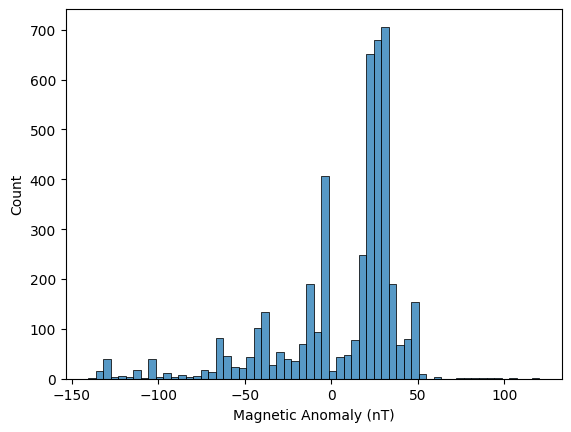

In [40]:
sns.histplot(cleaned_data['Magnetic Anomaly (nT)'], kde=False)

In [41]:
# Save the DataFrame to a new CSV file
cleaned_data.to_csv('cleaned_data.csv', index=False)

In [57]:
cleaned_data = pd.read_csv('cleaned_data.csv')

### Check data distribution

<Axes: xlabel='Apparent Geothermal Gradient (°C/Km)', ylabel='Count'>

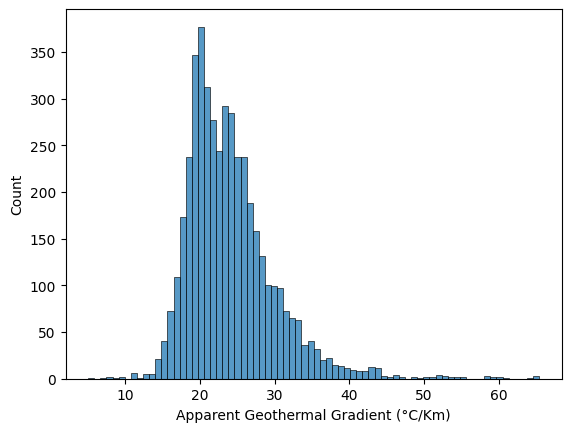

In [58]:
sns.histplot(cleaned_data['Apparent Geothermal Gradient (°C/Km)'], kde=False)

In [59]:
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m),LAB,Crustal Density (kg/m³),Lithospheric Density (kg/m³),Sub-Lithospheric Density (kg/m³),Flexural Rigidity (Pa⁻¹),Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²),Magnetic Anomaly (nT)
0,4.213002,-74.893581,313.9440,26.630280,14.712281,37601.741109,2,42863.912006,180982.196974,2908.355573,3351.741757,3471.512630,52.850111,0.980896,-0.571805,-0.409557,-43.6825
1,4.216078,-74.888898,313.3344,26.633328,21.294394,37852.172379,2,42855.311332,181091.851707,2908.222541,3351.727744,3471.560022,52.815770,0.980755,-0.571548,-0.409674,-43.6825
2,4.214720,-74.891220,316.3824,26.618088,23.783404,37716.838356,2,42859.265493,181040.260260,2908.280522,3351.734070,3471.537395,52.833159,0.980844,-0.571682,-0.409628,-43.6825
3,0.606276,-76.564731,275.2344,26.823828,24.156323,74806.593793,5,36310.810774,67583.917945,2835.980674,3282.586490,3441.440446,35.824963,0.635515,-0.359978,-0.269995,-3.9287
4,0.305911,-76.914853,90.5256,27.747372,25.601245,84902.242439,5,37832.879615,60788.349259,2840.500170,3278.407951,3438.858531,27.407060,0.586203,-0.318344,-0.262304,-2.2424


## Add fault proximity

In [60]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from tqdm import tqdm  # Import tqdm for the progress bar
import pandas as pd

# Load the shapefile
faults = gpd.read_file('data/Faults/faults.shp')

# Ensure the shapefile is in the correct coordinate system
faults = faults.to_crs('EPSG:3116')

# Create a GeoDataFrame from your dataset
# Replace 'Latitude' and 'Longitude' with your actual column names
gdf = gpd.GeoDataFrame(cleaned_data, geometry=gpd.points_from_xy(cleaned_data.Longitude, cleaned_data.Latitude), crs='EPSG:4326')

# Convert the GeoDataFrame to the same coordinate system as the shapefile
gdf = gdf.to_crs('EPSG:3116')

# Initialize an empty GeoDataFrame to store the distances
distances = gpd.GeoDataFrame()

# Loop through each point in the GeoDataFrame with tqdm for the progress bar
for index, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Calculating Nearest Faults"):
    # Find the nearest fault of each type for the current point
    nearest_fault = {}
    for fault_type in faults['Tipo'].unique():
        faults_of_type = faults[faults['Tipo'] == fault_type].copy()
        faults_of_type['geometry'] = faults_of_type['geometry'].centroid
        faults_of_type = faults_of_type.set_geometry('geometry')
        faults_of_type = faults_of_type.unary_union
        nearest = nearest_points(row['geometry'], faults_of_type)[1]
        nearest_fault[fault_type] = nearest.distance(row['geometry'])
    # Append the nearest faults to the GeoDataFrame
    distances = pd.concat([distances, gpd.GeoDataFrame(nearest_fault, index=[index])])

# Add the new columns to the original DataFrame
cleaned_data = pd.concat([cleaned_data, distances], axis=1)

Calculating Nearest Faults: 100%|██████████| 4543/4543 [07:54<00:00,  9.58it/s]


In [62]:
cleaned_data.columns

Index(['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)',
       'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
       'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
       'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
       'Flexural Rigidity (Pa⁻¹)',
       'Gravitational Acceleration z-component (m/s²)',
       'Gravitational Acceleration x-component (m/s²)',
       'Gravitational Acceleration y-component (m/s²)',
       'Magnetic Anomaly (nT)', 'Falla', 'Falla cubierta',
       'Falla de rumbo sinestral', 'Falla inversa o de cabalgamiento cubierta',
       'Falla inversa o de cabalgamiento', 'Lineamiento',
       'Falla de rumbo dextral', 'Falla de rumbo sinestral cubierta',
       'Falla de rumbo dextral cubierta', 'Falla inferida',
       'Falla normal cubierta', 'Falla de rumbo sinestral inferida',
       'Falla normal inferida', 'Falla normal',
       'Falla inversa o

Each fault has 2 additional sub-types: "cubierta" and "inferida", so let's compute the nearest among the three and leave each fault type as a single column.

In [63]:
# List of fault types including "Lineamiento"
fault_types = ['Falla', 'Falla de rumbo sinestral', 'Falla inversa o de cabalgamiento', 'Lineamiento', 'Falla de rumbo dextral', 'Falla normal']

# Iterate through each fault type
for fault_type in fault_types:
    # Skip the consolidation process for "Lineamiento"
    if fault_type == 'Lineamiento':
        continue
    
    # Create a new column with the minimum distance among the original, 'cubierta', and 'inferida' columns
    cleaned_data[fault_type] = cleaned_data[[f'{fault_type} cubierta', f'{fault_type} inferida', fault_type]].min(axis=1)

    # Drop the redundant 'cubierta' and 'inferida' columns
    cleaned_data = cleaned_data.drop([f'{fault_type} cubierta', f'{fault_type} inferida'], axis=1)

In [68]:
cleaned_data.columns

Index(['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)',
       'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
       'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
       'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
       'Flexural Rigidity (Pa⁻¹)',
       'Gravitational Acceleration z-component (m/s²)',
       'Gravitational Acceleration x-component (m/s²)',
       'Gravitational Acceleration y-component (m/s²)',
       'Magnetic Anomaly (nT)', 'Falla', 'Falla de rumbo sinestral',
       'Falla inversa o de cabalgamiento', 'Lineamiento',
       'Falla de rumbo dextral', 'Falla normal'],
      dtype='object')

In [69]:
# Define a mapping of old column names to new column names
column_mapping = {
    'Falla': 'Fault',
    'Falla de rumbo sinestral': 'Strike-slip Fault',
    'Falla inversa o de cabalgamiento': 'Reverse or Thrust Fault',
    'Lineamiento': 'Lineament',
    'Falla de rumbo dextral': 'Right-lateral Fault',
    'Falla normal': 'Normal Fault'
}


# Rename columns
cleaned_data.rename(columns=column_mapping, inplace=True)

In [71]:
cleaned_data.to_csv('cleaned_faults.csv', index=False)

In [74]:
cleaned_data = pd.read_csv('cleaned_faults.csv')
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m),LAB,Crustal Density (kg/m³),...,Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault
0,4.213002,-74.893581,313.9440,26.630280,14.712281,37601.741109,2,42863.912006,180982.196974,2908.355573,...,0.980896,-0.571805,-0.409557,-43.6825,16042.943074,38240.015578,7608.200346,32274.809475,38166.067805,178510.268973
1,4.216078,-74.888898,313.3344,26.633328,21.294394,37852.172379,2,42855.311332,181091.851707,2908.222541,...,0.980755,-0.571548,-0.409674,-43.6825,15471.824393,37942.352312,8075.823613,32849.251541,38767.181198,179076.006649
2,4.214720,-74.891220,316.3824,26.618088,23.783404,37716.838356,2,42859.265493,181040.260260,2908.280522,...,0.980844,-0.571682,-0.409628,-43.6825,15751.330619,38097.704215,7838.753798,32567.674193,38474.927997,178798.267287
3,0.606276,-76.564731,275.2344,26.823828,24.156323,74806.593793,5,36310.810774,67583.917945,2835.980674,...,0.635515,-0.359978,-0.269995,-3.9287,35178.987807,61605.456789,39427.671692,110966.615285,57996.892585,321929.890761
4,0.305911,-76.914853,90.5256,27.747372,25.601245,84902.242439,5,37832.879615,60788.349259,2840.500170,...,0.586203,-0.318344,-0.262304,-2.2424,36371.533982,52965.253274,34306.255135,94735.671514,87776.161121,355936.702855


## Active faults

In [75]:
import geopandas as gpd
from shapely.ops import nearest_points
from tqdm import tqdm
import pandas as pd

# Load the active faults shapefile
active_faults_path = 'data/Faults/Active/ATA.shp'
active_faults = gpd.read_file(active_faults_path)
active_faults = active_faults.to_crs('EPSG:3116')


# Create a GeoDataFrame from your dataset
# Replace 'Latitude' and 'Longitude' with your actual column names
gdf = gpd.GeoDataFrame(cleaned_data, geometry=gpd.points_from_xy(cleaned_data.Longitude, cleaned_data.Latitude), crs='EPSG:4326')

# Convert the GeoDataFrame to the same coordinate system as the active faults
gdf = gdf.to_crs(active_faults.crs)

# Initialize an empty DataFrame to store distances to active faults
active_faults_distances = pd.DataFrame()

# Loop through each point in the GeoDataFrame with tqdm for the progress bar
for index, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Calculating Distances to Active Faults"):
    # Find the nearest active fault for the current point
    nearest_active_fault = nearest_points(row['geometry'], active_faults.unary_union)[1]
    
    # Calculate the distance and store it in the DataFrame
    distance_to_active_fault = nearest_active_fault.distance(row['geometry'])
    active_faults_distances.at[index, 'Active Fault'] = distance_to_active_fault

# Add the new column to the original DataFrame
cleaned_data = pd.concat([cleaned_data, active_faults_distances], axis=1)

Calculating Distances to Active Faults: 100%|██████████| 4543/4543 [00:25<00:00, 176.31it/s]


In [76]:
cleaned_data

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m),LAB,Crustal Density (kg/m³),...,Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault
0,4.213002,-74.893581,313.9440,26.630280,14.712281,37601.741109,2,42863.912006,180982.196974,2908.355573,...,-0.571805,-0.409557,-43.6825,16042.943074,38240.015578,7608.200346,32274.809475,38166.067805,178510.268973,12107.518869
1,4.216078,-74.888898,313.3344,26.633328,21.294394,37852.172379,2,42855.311332,181091.851707,2908.222541,...,-0.571548,-0.409674,-43.6825,15471.824393,37942.352312,8075.823613,32849.251541,38767.181198,179076.006649,12521.081516
2,4.214720,-74.891220,316.3824,26.618088,23.783404,37716.838356,2,42859.265493,181040.260260,2908.280522,...,-0.571682,-0.409628,-43.6825,15751.330619,38097.704215,7838.753798,32567.674193,38474.927997,178798.267287,12309.048726
3,0.606276,-76.564731,275.2344,26.823828,24.156323,74806.593793,5,36310.810774,67583.917945,2835.980674,...,-0.359978,-0.269995,-3.9287,35178.987807,61605.456789,39427.671692,110966.615285,57996.892585,321929.890761,38740.878594
4,0.305911,-76.914853,90.5256,27.747372,25.601245,84902.242439,5,37832.879615,60788.349259,2840.500170,...,-0.318344,-0.262304,-2.2424,36371.533982,52965.253274,34306.255135,94735.671514,87776.161121,355936.702855,36506.159761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4538,9.198753,-74.545831,14.9352,28.125324,22.902864,397344.361785,1,37255.351981,84164.260348,2730.346795,...,-0.084762,0.134413,-29.3196,67951.218564,84851.479187,56595.020520,88505.305904,64495.836547,259372.804468,80852.179701
4539,9.193783,-74.545203,17.6784,28.111608,23.599190,396803.395895,1,37242.152495,84068.472549,2730.547662,...,-0.085066,0.134120,-29.3196,67503.732300,84298.012717,56071.263149,87971.739857,64199.313789,258821.634484,80298.996774
4540,9.210378,-74.266786,21.3360,28.093320,22.529272,403311.884658,1,37076.390931,91373.561373,2745.921851,...,-0.114714,0.137506,-59.0881,49589.080907,56467.948967,52443.767658,83005.223439,40008.137041,255540.784076,69911.233325
4541,8.213381,-72.470731,86.8680,27.765660,23.098588,395974.286510,1,36883.953489,146712.394810,2824.115171,...,-0.179193,-0.046182,21.7434,9812.610984,94782.592997,11630.076088,196307.990555,38178.497828,223384.739466,5879.044197


In [77]:
cleaned_data.columns

Index(['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
       'Apparent Geothermal Gradient (°C/Km)',
       'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
       'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
       'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
       'Flexural Rigidity (Pa⁻¹)',
       'Gravitational Acceleration z-component (m/s²)',
       'Gravitational Acceleration x-component (m/s²)',
       'Gravitational Acceleration y-component (m/s²)',
       'Magnetic Anomaly (nT)', 'Fault', 'Strike-slip Fault',
       'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
       'Normal Fault', 'Active Fault'],
      dtype='object')

## Normalization of the data

Input data needs to be normalized as the features are in different scales. Target (heat flow) is not being normalized.

In [78]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Elevation (m)', 'Surface Temperature (°C)', 'Magnetic Anomaly (nT)',
                        'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
                        'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)',
                        'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
                        'Flexural Rigidity (Pa⁻¹)','Fault', 'Strike-slip Fault',
                        'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
                        'Normal Fault', 'Active Fault']

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
cleaned_data[columns_to_normalize] = scaler.fit_transform(cleaned_data[columns_to_normalize])

# Save the normalized data to a new CSV file
cleaned_data.to_csv('normalized_data_minmax.csv', index=False)

In [79]:
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m),LAB,Crustal Density (kg/m³),...,Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault
0,4.213002,-74.893581,0.100752,0.899248,14.712281,0.034231,0.142857,0.720860,0.888720,0.874119,...,-0.571805,-0.409557,0.371683,0.055508,0.105702,0.021543,0.073640,0.100585,0.417515,0.035052
1,4.216078,-74.888898,0.100557,0.899443,21.294394,0.034546,0.142857,0.720455,0.889526,0.873629,...,-0.571548,-0.409674,0.371683,0.053527,0.104876,0.022877,0.075174,0.102181,0.418871,0.036250
2,4.214720,-74.891220,0.101535,0.898465,23.783404,0.034375,0.142857,0.720641,0.889146,0.873843,...,-0.571682,-0.409628,0.371683,0.054497,0.105307,0.022201,0.074422,0.101405,0.418205,0.035636
3,0.606276,-76.564731,0.088329,0.911671,24.156323,0.080993,0.571429,0.412171,0.054855,0.607128,...,-0.359978,-0.269995,0.524208,0.121886,0.170555,0.112310,0.283746,0.153212,0.761431,0.112189
4,0.305911,-76.914853,0.029052,0.970948,25.601245,0.093682,0.571429,0.483869,0.004884,0.623801,...,-0.318344,-0.262304,0.530678,0.126023,0.146573,0.097701,0.240410,0.232241,0.842979,0.105716


## Read the normalized dataset

In [42]:
cleaned_data = pd.read_csv('normalized_data_minmax.csv')
cleaned_data.head()

,Latitude,Longitude,Elevation (m),Surface Temperature (°C),Apparent Geothermal Gradient (°C/Km),Distance To Nearest Volcano (m),Number of Volcanoes Nearby,Moho Depth (m),LAB,Crustal Density (kg/m³),...,Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²),Magnetic Anomaly (nT),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault
0,4.213002,-74.893581,0.100752,0.899248,14.712281,0.034231,0.142857,0.720860,0.888720,0.874119,...,-0.571805,-0.409557,0.371683,0.055508,0.105702,0.021543,0.073640,0.100585,0.417515,0.035052
1,4.216078,-74.888898,0.100557,0.899443,21.294394,0.034546,0.142857,0.720455,0.889526,0.873629,...,-0.571548,-0.409674,0.371683,0.053527,0.104876,0.022877,0.075174,0.102181,0.418871,0.036250
2,4.214720,-74.891220,0.101535,0.898465,23.783404,0.034375,0.142857,0.720641,0.889146,0.873843,...,-0.571682,-0.409628,0.371683,0.054497,0.105307,0.022201,0.074422,0.101405,0.418205,0.035636
3,0.606276,-76.564731,0.088329,0.911671,24.156323,0.080993,0.571429,0.412171,0.054855,0.607128,...,-0.359978,-0.269995,0.524208,0.121886,0.170555,0.112310,0.283746,0.153212,0.761431,0.112189
4,0.305911,-76.914853,0.029052,0.970948,25.601245,0.093682,0.571429,0.483869,0.004884,0.623801,...,-0.318344,-0.262304,0.530678,0.126023,0.146573,0.097701,0.240410,0.232241,0.842979,0.105716


## Correlation Matrix

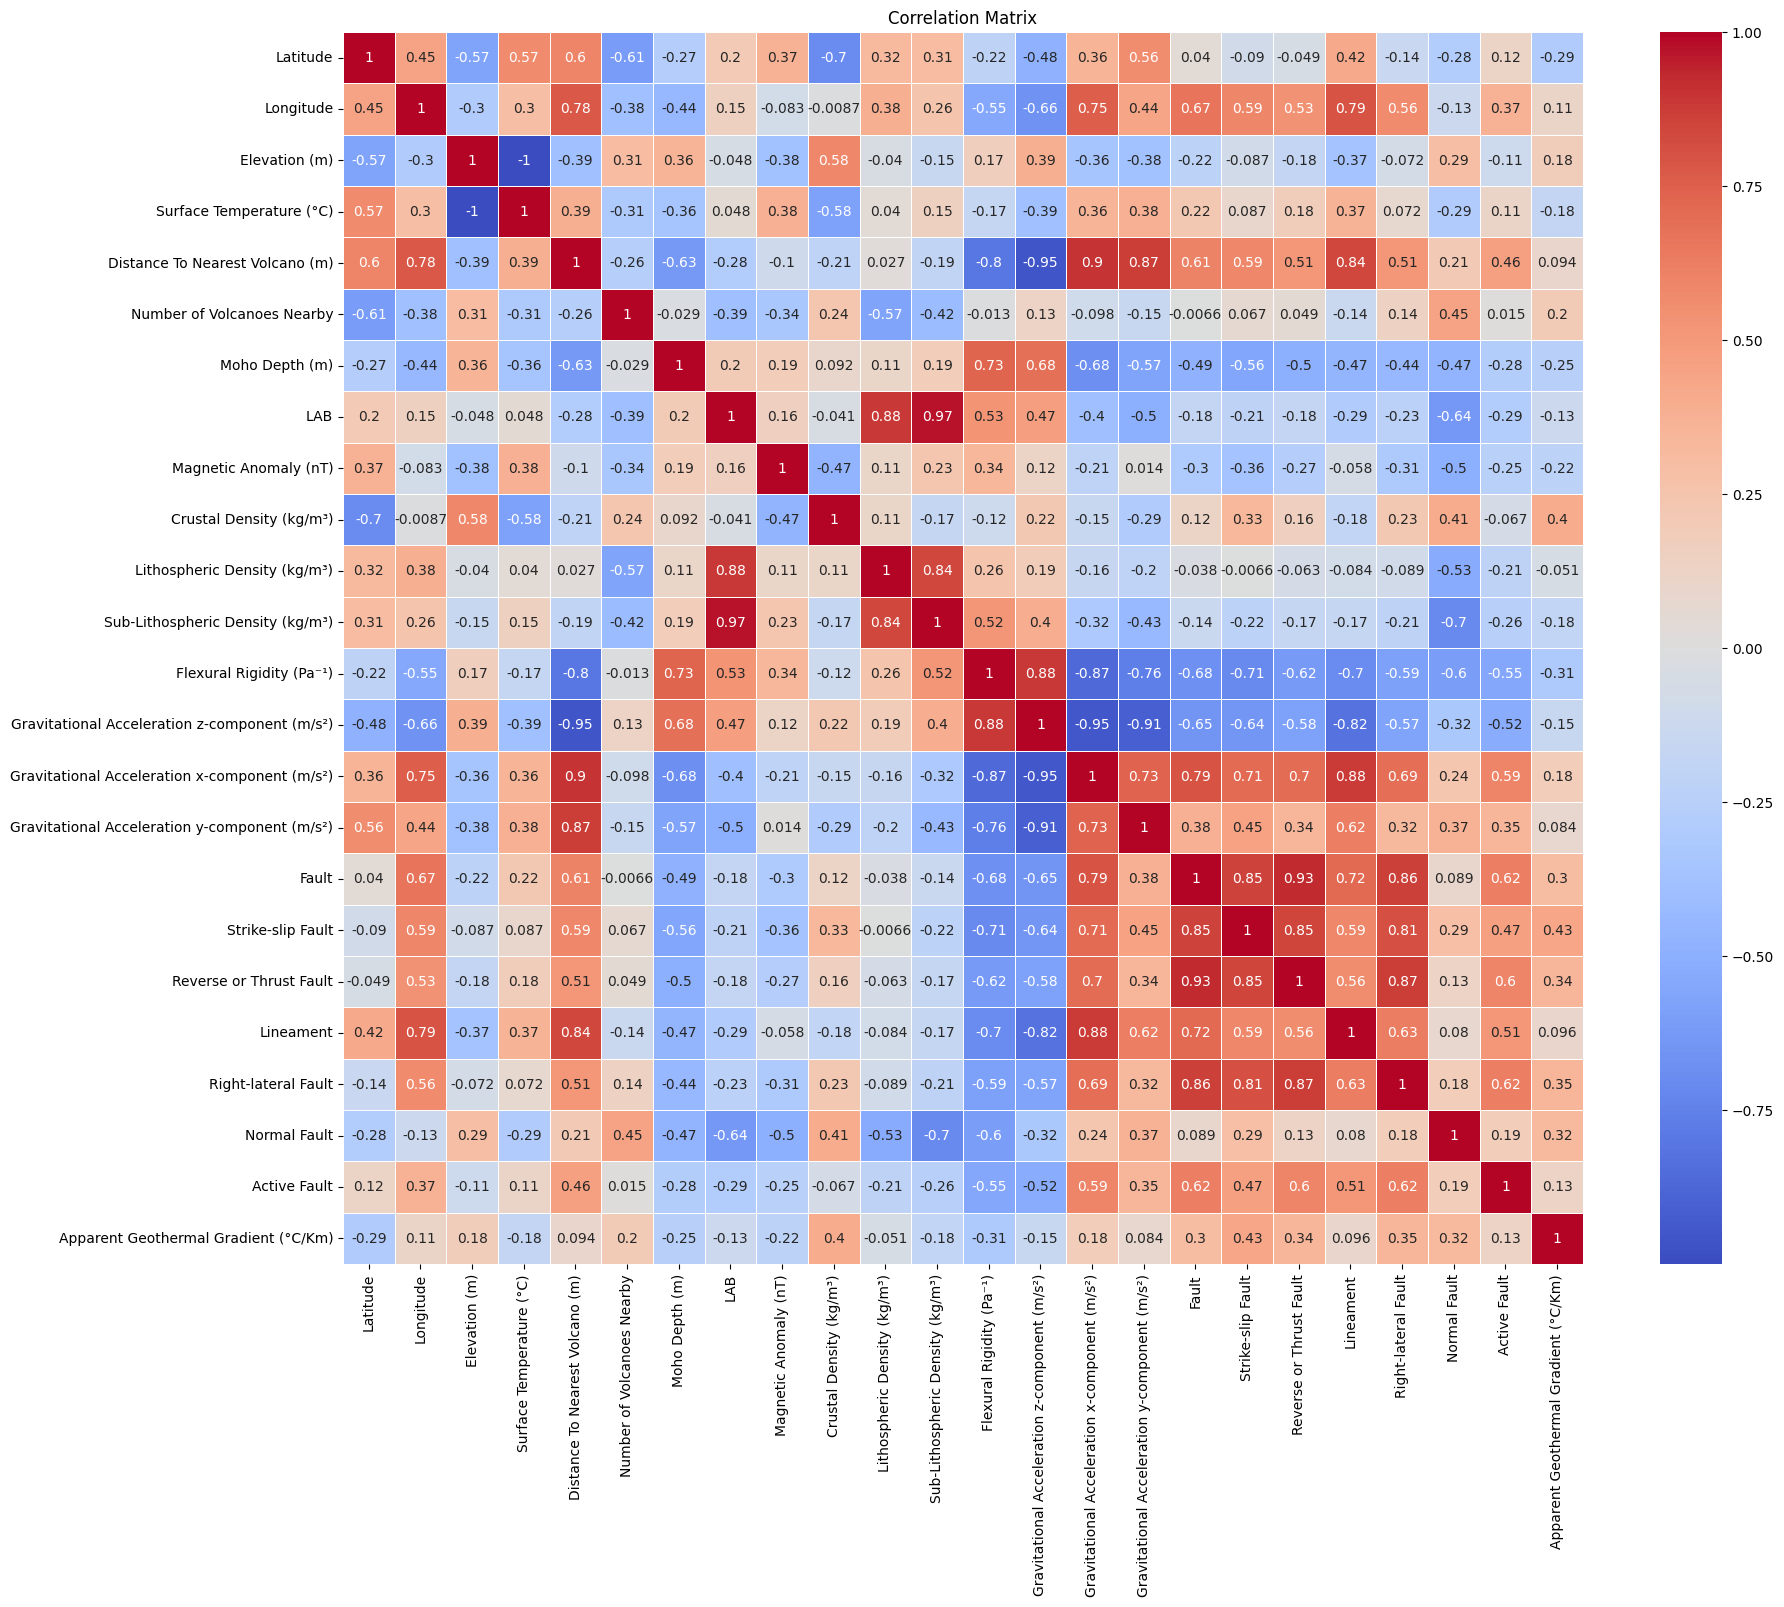

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the desired columns
selected_columns = ['Latitude', 'Longitude', 'Elevation (m)', 'Surface Temperature (°C)',
                     'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
                     'Moho Depth (m)', 'LAB', 'Magnetic Anomaly (nT)', 'Crustal Density (kg/m³)',
                     'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
                     'Flexural Rigidity (Pa⁻¹)',
                     'Gravitational Acceleration z-component (m/s²)',
                     'Gravitational Acceleration x-component (m/s²)',
                     'Gravitational Acceleration y-component (m/s²)','Fault',
                     'Strike-slip Fault',
                     'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
                     'Normal Fault', 'Active Fault', 
                     'Apparent Geothermal Gradient (°C/Km)']

# Create a DataFrame with the selected columns
selected_data = cleaned_data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Building Machine Learning Algorithm

## Data Splitting

In [43]:
# Define feature matrix (X) and target variables (y)
X = cleaned_data[['Latitude', 'Longitude','Elevation (m)',
        'Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
        'Moho Depth (m)', 'LAB', 'Magnetic Anomaly (nT)', 'Crustal Density (kg/m³)',
        'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
        'Gravitational Acceleration z-component (m/s²)',
        'Gravitational Acceleration x-component (m/s²)',
        'Gravitational Acceleration y-component (m/s²)',
        'Fault',
        'Strike-slip Fault',
        'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
        'Normal Fault', 'Active Fault']]

y = cleaned_data['Apparent Geothermal Gradient (°C/Km)']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save X_test with lat and lon for plotting later
X_test_with_lat_lon = X_test[['Latitude', 'Longitude']].copy()

# Save X with lat and lon for plotting later
X_lat_lon = X[['Latitude', 'Longitude']].copy()

# Remove lat and lon from X to predict on the whole dataset
X = X.drop(['Latitude', 'Longitude'], axis=1)

#Remove lat and lon from X_train and X_test
X_train = X_train.drop(['Latitude', 'Longitude'], axis=1)
X_test = X_test.drop(['Latitude', 'Longitude'], axis=1)

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Hyperparameter Tuning with Cross-Validation

Manually iterating over hyperparameter combinations and recording the progress using the tqdm library. 

In [179]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import numpy as np
from tqdm import tqdm

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [5, 7, 10],
    'min_child_weight': [2, 5.0, 7.5],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],  # Number of boosting rounds
    'gamma': [1.0],  # Regularization parameter
}

best_params = {}
best_mse = float('inf')

# Use tqdm to display a progress bar
for params in tqdm(list(ParameterGrid(param_grid))):
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    if mse < best_mse:
        best_params = params
        best_mse = mse

print("Best Hyperparameters:", best_params)
print("Best Mean Squared Error:", best_mse)

100%|██████████| 36/36 [02:25<00:00,  4.05s/it]

Best Hyperparameters: {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5.0, 'n_estimators': 100}
Best Mean Squared Error: 24.537892896200887


## Train XGBoost and evaluate model

In [180]:
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=5.0, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Evaluate the model's performance on the test data using appropriate regression metrics (e.g., MAE, RMSE, R-squared).

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = best_xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

In [47]:
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Mean Absolute Error: 2.878354528228713
Root Mean Squared Error: 4.934463729038201
R-squared: 0.3759952781496878


# Visualization of results

## Feature Importance Plot

Visualize the importance of each feature in the Random Forest model. This will help to understand which features have the most significant impact on predicting the geothermal gradient.

<Figure size 2000x3000 with 0 Axes>

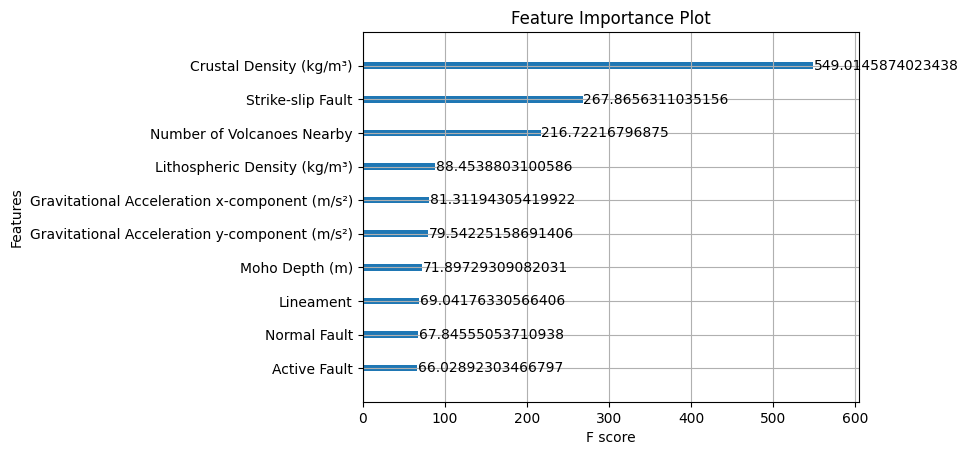

In [48]:
# Plot feature importance
plt.figure(figsize=(20, 30))
xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=10)
plt.title('Feature Importance Plot')
plt.show()

## Residual Plot

Create a residual plot to check if the model's predictions have a pattern. Most residuals must be near to zero

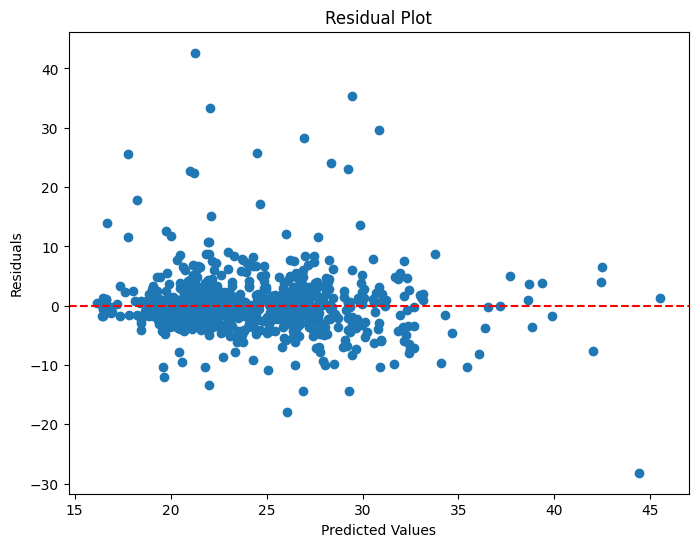

In [49]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.show()

## Actual vs. Predicted Plot

Visualize how model's predictions compare to the actual values.

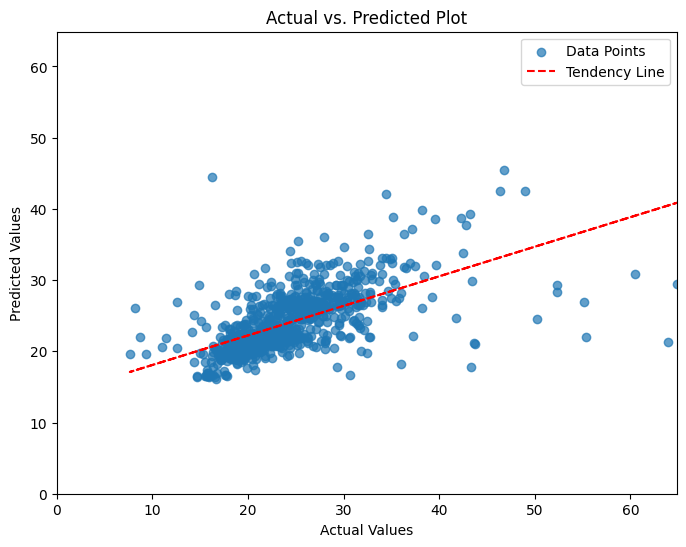

In [50]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Data Points', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Plot')

# Set x and y axis limits to start at 0,0
plot_max = max(max(y_test), max(y_pred))
plt.xlim(0, plot_max)
plt.ylim(0, plot_max)

# Fit a linear regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), color='red', linestyle='--', label='Tendency Line')

plt.legend()
plt.show()

## Other plots

### Save the model

In [44]:
import joblib

In [ ]:
joblib.dump(best_xgb_model, 'trained_model.pkl')

['trained_model.pkl']

Load the model

In [45]:
best_xgb_model = joblib.load('trained_model.pkl')

## Geospatial visualization

### Actual data

In [ ]:
import geopandas as gpd

In [186]:
actual_data = pd.read_csv('cleaned_data.csv')

### Predicted data

In [187]:
# Make predictions using the entire dataset (X)
y_pred_full = best_xgb_model.predict(X)

# Update your existing DataFrame or create a new one to store the predictions
X_lat_lon['Predicted Geothermal Gradient (°C/Km)'] = y_pred_full

In [188]:
X_lat_lon.head()

,Latitude,Longitude,Predicted Geothermal Gradient (°C/Km)
0,4.213002,-74.893581,16.858416
1,4.216078,-74.888898,22.958824
2,4.214720,-74.891220,22.286482
3,0.606276,-76.564731,25.440060
4,0.305911,-76.914853,26.555613


In [189]:
X_lat_lon.to_csv('predicted_dataset.csv', index=False)

In [190]:
X_lat_lon = pd.read_csv('predicted_dataset.csv')

### Plot actual and predicted

/tmp/ipykernel_21655/1906445481.py:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


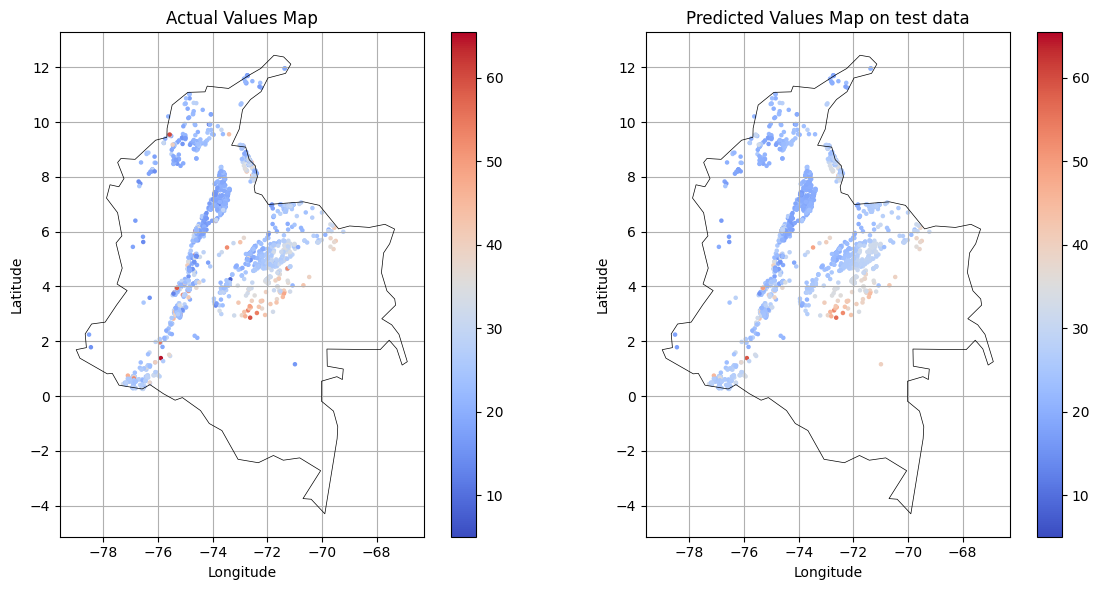

In [191]:
# Load GeoDataFrame for actual values
actual_gdf = gpd.GeoDataFrame(actual_data, geometry=gpd.points_from_xy(actual_data['Longitude'], actual_data['Latitude']))

# Load GeoDataFrame for predicted values
predicted_gdf = gpd.GeoDataFrame(X_lat_lon, geometry=gpd.points_from_xy(X_lat_lon['Longitude'], X_lat_lon['Latitude']))

# Determine the common color range
vmin = min(actual_gdf['Apparent Geothermal Gradient (°C/Km)'].min(), predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].min())
vmax = max(actual_gdf['Apparent Geothermal Gradient (°C/Km)'].max(), predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].max())

# Create subplots with two axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot actual values on the first subplot
actual_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=axes[0], vmin=vmin, vmax=vmax)
axes[0].set_title('Actual Values Map')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot predicted values on the second subplot
predicted_plot = predicted_gdf.plot(column='Predicted Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=axes[1], vmin=vmin, vmax=vmax)
axes[1].set_title('Predicted Values Map on test data')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon to both subplots
for ax in axes:
    ax.set_xticks(lon_grid)
    ax.set_yticks(lat_grid)
    ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest for both subplots
for ax in axes:
    world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the combined plot with both subplots
plt.tight_layout()
plt.show()


### Difference between actual and predicted

/tmp/ipykernel_21655/4261831172.py:23: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


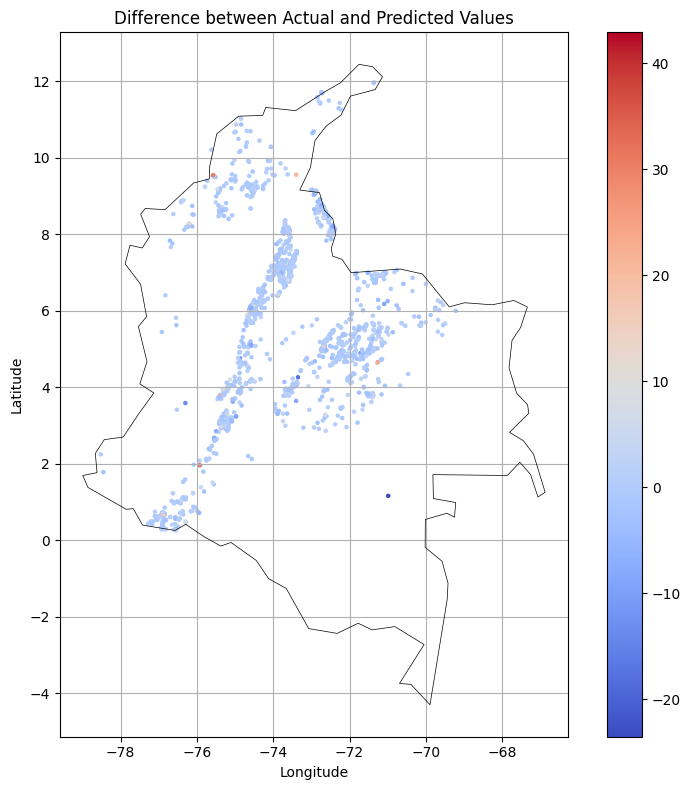

In [192]:
# Calculate the difference between actual and predicted values
actual_gdf['Apparent Geothermal Gradient (°C/Km)'] = actual_gdf['Apparent Geothermal Gradient (°C/Km)'] - predicted_gdf['Predicted Geothermal Gradient (°C/Km)']

# Create a plot for the difference values
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
difference_plot = actual_gdf.plot(column='Apparent Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=ax)
ax.set_title('Difference between Actual and Predicted Values')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Calculate grid positions based on min and max latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for lat and lon
ax.set_xticks(lon_grid)
ax.set_yticks(lat_grid)
ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest
world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the plot
plt.tight_layout()
plt.show()


# Predicting new values (Colombia)

We'll use a Colombia Cities Database to extract latitude and longitude data for the whole country (over 8000 geographic points)

In [ ]:
cities = pd.read_excel('data/8. Clasificador Geográfico.xlsx')
cities = cities.rename(columns={"Longitud": "Longitude", "Latitud": "Latitude"})
cities.head()

,Código Departamento,Código Municipio,Código Centro Poblado,Nombre Departamento,Nombre Municipio,Nombre Centro Poblado,Tipo Centro Poblado,Longitude,Unnamed: 8,Latitude,Distrito,Tipo de Municipio,Area Metropolitana
0,5,5001,5001000,ANTIOQUIA,MEDELLÍN,MEDELLÍN,CABECERA MUNICIPAL (CM),-75.576002,NaN,6.248586,NaN,MUNICIPIO,AREA METROPOLITANA DEL VALLE DE ABURRÁ
1,5,5001,5001001,ANTIOQUIA,MEDELLÍN,PALMITAS,CABECERA CORREGIMIENTO MUNICIPAL (C),-75.689986,NaN,6.343922,NaN,MUNICIPIO,AREA METROPOLITANA DEL VALLE DE ABURRÁ
2,5,5001,5001004,ANTIOQUIA,MEDELLÍN,SANTA ELENA,CABECERA CORREGIMIENTO MUNICIPAL (C),-75.500317,NaN,6.209675,NaN,MUNICIPIO,AREA METROPOLITANA DEL VALLE DE ABURRÁ
3,5,5001,5001009,ANTIOQUIA,MEDELLÍN,ALTAVISTA,CABECERA CORREGIMIENTO MUNICIPAL (C),-75.629944,NaN,6.222483,NaN,MUNICIPIO,AREA METROPOLITANA DEL VALLE DE ABURRÁ
4,5,5001,5001010,ANTIOQUIA,MEDELLÍN,AGUAS FRÍAS,CABECERA CORREGIMIENTO MUNICIPAL (C),-75.633946,NaN,6.233336,NaN,MUNICIPIO,AREA METROPOLITANA DEL VALLE DE ABURRÁ


In [ ]:
cities.to_csv('cities.csv', index=False)

In [ ]:
cities = pd.read_csv('cities.csv')

We'll clean unnecesary data

In [ ]:
points = cities[['Latitude', 'Longitude']].copy()

In [ ]:
points.head()

,Latitude,Longitude
0,6.248586,-75.576002
1,6.343922,-75.689986
2,6.209675,-75.500317
3,6.222483,-75.629944
4,6.233336,-75.633946


Generate random latitude and longitude points along the country

In [ ]:
import geopandas as gpd
import random
import pandas as pd
from shapely.geometry import Point
from tqdm import tqdm

# Load the shapefile for Colombia
colombia = gpd.read_file('data/COL_adm0.shp')

# Get the Polygon for Colombia
colombia_polygon = colombia.geometry.unary_union

# Define the bounding box of the polygon
bbox = colombia_polygon.bounds

# Number of random points to generate
num_points = 30000

# Generate random points within the bounding rectangle
random_points = []

while len(random_points) < num_points:
    random_lon = random.uniform(bbox[0], bbox[2])
    random_lat = random.uniform(bbox[1], bbox[3])
    random_point = Point(random_lon, random_lat)
    random_points.append({'Longitude': random_point.x, 'Latitude': random_point.y})

In [130]:
# Create a list to store filtered points
filtered_points = []

progress_bar = tqdm(total=num_points, position=0)

# Filter points to keep only those within the Colombia shape
for point in tqdm(random_points, position=1, desc="Filtering Points"):
    if Point(point['Longitude'], point['Latitude']).within(colombia_polygon):
        filtered_points.append(point)
    progress_bar.update(1)

progress_bar.close()

# Create a DataFrame with the generated and filtered points
points = pd.DataFrame(filtered_points)

100%|██████████| 30000/30000 [34:16<00:00, 14.59it/s]


In [131]:
points

,Longitude,Latitude
0,-75.270945,4.121837
1,-75.727019,2.037692
2,-74.755559,6.897459
3,-70.877470,0.648542
4,-74.274264,6.783008
...,...,...
9250,-70.737656,-1.683985
9251,-76.658445,2.638275
9252,-70.223321,-0.659742
9253,-74.349032,5.329794


In [132]:
points.to_csv('points.csv', index = False)

In [ ]:
points = pd.read_csv('points.csv')

We'll add elevation/altitude to our dataframe using WorldDEM.tif. File elevation data is originally scaled 0-6400 meters.

In [133]:
import rasterio
from pyproj import CRS, Transformer

# Rescale the elevation values to get actual values as they are downscaled 0-6400 meters
def rescale(val, in_min, in_max, out_min, out_max):
    return out_min + (val - in_min) * ((out_max - out_min) / (in_max - in_min))

def get_elevation(lat, lon, dem='data/WorldDEM.tif'):
    with rasterio.open(dem) as src:
        # Define coordinate systems
        in_crs = CRS("EPSG:4326")  # Input coordinate system (WGS84)
        out_crs = src.crs  # Output coordinate system (raster's crs)

        # Create a transformer object
        transformer = Transformer.from_crs(in_crs, out_crs, always_xy=True)

        # Transform coordinates
        lon, lat = transformer.transform(lon, lat)

        # Sample the raster at the transformed coordinates
        vals = src.sample([(lon, lat)])
        for val in vals:
            # Upscale the elevation value
            elevation = rescale(val[0], 0, 255, 0, 6400) # 0 and 255 are the min and max values of the DEM
    return elevation


# Use tqdm to show progress
tqdm.pandas()

# Apply the function to each row in your DataFrame
points['Elevation (m)'] = points.progress_apply(lambda row: get_elevation(row['Latitude'], row['Longitude']), axis=1)


  0%|          | 18/9255 [00:00<02:27, 62.43it/s]

100%|██████████| 9255/9255 [01:09<00:00, 133.50it/s]


## Now we need to do what we did before for volcanoes, Moho depht, LAB, etc; but for these data

Nearest Volcano

In [134]:
import math

# Load the "points" dataset into GeoDataFrames
points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['Longitude'], points['Latitude']))
volcanos_gdf = gpd.GeoDataFrame(volcanos, geometry=gpd.points_from_xy(volcanos['Lon'], volcanos['Lat']))

# Initialize an empty list to store distances to the nearest volcano (in meters)
distances_to_nearest_volcano_2 = []

# Radius of the Earth in meters
earth_radius = 6371000  # Approximately

# Iterate through each well
for well in points_gdf.itertuples():
    nearest_volcano_distance = float('inf')  # Initialize with a large value
    
    # Iterate through each volcano to find the nearest one
    for volcano in volcanos_gdf.itertuples():
        # Haversine formula to calculate the great-circle distance
        lon1, lat1 = well.geometry.x, well.geometry.y
        lon2, lat2 = volcano.geometry.x, volcano.geometry.y

        dlon = math.radians(lon2 - lon1)
        dlat = math.radians(lat2 - lat1)

        a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        distance = earth_radius * c
        nearest_volcano_distance = min(nearest_volcano_distance, distance)
    
    distances_to_nearest_volcano_2.append(nearest_volcano_distance)

# Add the distances to the "points" dataset as a new column (in meters)
points['Distance To Nearest Volcano (m)'] = distances_to_nearest_volcano_2

Near volcanoes

In [135]:
import geopy.distance

# The radius is the distance to the nearest volcano plus 5000 meters (5 kilometers)
points['Radius (m)'] = points['Distance To Nearest Volcano (m)'] + 5000
points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['Longitude'], points['Latitude']))

# Initialize an empty list to store the counts of nearby volcanoes
num_volcanoes_nearby_2 = []

# Iterate through each well to count nearby volcanoes
for index, row in points.iterrows():
    well_location = (row['Latitude'], row['Longitude'])
    radius = row['Radius (m)']
    
    # Calculate the number of volcanoes within the specified radius
    num_nearby_volcanoes = len(volcanos[
        volcanos.apply(lambda x: geopy.distance.distance(well_location, (x['Lat'], x['Lon'])).m <= radius, axis=1)
    ])
    
    num_volcanoes_nearby_2.append(num_nearby_volcanoes)

# Add the "Number of Volcanoes Nearby" feature to the "points" dataset
points['Number of Volcanoes Nearby'] = num_volcanoes_nearby_2

Moho depth

In [136]:
from scipy.interpolate import griddata
from tqdm import tqdm

points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['Longitude'], points['Latitude']))
moho_depth_gdf = gpd.GeoDataFrame(moho_depth, geometry=gpd.points_from_xy(moho_depth['Lon'], moho_depth['Lat']))

# Convert GeoDataFrames to numpy arrays
points_array = points_gdf[['Longitude', 'Latitude']].values
moho_depth_array = moho_depth_gdf[['Lon', 'Lat', 'Moho Depth (m)']].values

# Separate the coordinates and values
coordinates, values = moho_depth_array[:, :2], moho_depth_array[:, 2]

# Initialize tqdm for progress bar
pbar = tqdm(total=len(points_array), desc="Interpolating", ncols=100)

# Initialize an empty list to store interpolated Moho depth values for each well
moho_depth_values = []

# Iterate through each well
for point in points_array:
    # Use griddata for interpolation
    moho_depth_value = griddata(coordinates, values, [point], method='cubic')
    
    # Append the interpolated Moho depth value to the list
    moho_depth_values.append(moho_depth_value[0])
    
    # Update the progress bar
    pbar.update()

# Close the progress bar
pbar.close()

# Add the interpolated Moho depth values to the "points" dataset as a new column
points['Moho Depth (m)'] = moho_depth_values

Interpolating:   0%|                                                       | 0/9255 [00:00<?, ?it/s]

Interpolating: 100%|████████████████████████████████████████████| 9255/9255 [02:29<00:00, 61.82it/s]


Magnetic Anomaly

In [137]:
import rasterio
from rasterio.warp import transform

# Load the TIFF file
src = rasterio.open('data/Mag_anom_col.tif')

# Define a function to get the value from the TIFF file
def get_value_from_tiff(lat, lon):
    # Adjust longitudes greater than 180
    if lon > 180:
        lon = lon - 360
    # Transform lat, lon to the coordinate system of the tiff
    x, y = transform('EPSG:4326', src.crs, [lon], [lat])
    # Get the value at the transformed coordinate
    for val in src.sample([(x[0], y[0])]):
        return val[0]

# Apply the function to each row in the dataframe
points['Magnetic Anomaly (nT)'] = points.apply(lambda row: get_value_from_tiff(row['Latitude'], row['Longitude']), axis=1)

In [138]:
points.to_csv('points_withoutoutliers.csv', index=False)

In [139]:
points = pd.read_csv('points_withoutoutliers.csv')
points

,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT)
0,-75.270945,4.121837,602.352941,32497.771613,37497.771613,2,44125.857505,-44.2309
1,-75.727019,2.037692,953.725490,37811.874914,42811.874914,4,43955.083618,-10.9778
2,-74.755559,6.897459,828.235294,140647.299416,145647.299416,1,36707.256671,3.5249
3,-70.877470,0.648542,250.980392,573899.761954,578899.761954,1,32624.339236,-42.4339
4,-74.274264,6.783008,100.392157,147125.970140,152125.970140,1,38517.942159,25.9716
...,...,...,...,...,...,...,...,...
9250,-70.737656,-1.683985,100.392157,683119.791835,688119.791835,1,32614.287917,23.8052
9251,-76.658445,2.638275,1706.666667,46480.491513,51480.491513,9,42355.207626,-43.3653
9252,-70.223321,-0.659742,100.392157,687963.244195,692963.244195,1,32975.167057,-30.2647
9253,-74.349032,5.329794,1405.490196,76380.186938,81380.186938,2,43770.612547,16.6156


In [140]:
points = points[(points['Magnetic Anomaly (nT)'] >= -363.13598632812) & 
                             (points['Magnetic Anomaly (nT)'] <= 548.34930419922)]

LAB depht and the rest of the features

In [141]:
from scipy.interpolate import griddata

# Create GeoDataFrames from datasets
points_gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points['Longitude'], points['Latitude']))
lab_depth_gdf = gpd.GeoDataFrame(lab_depth, geometry=gpd.points_from_xy(lab_depth['Lon'], lab_depth['Lat']))

# Define the grid points for interpolation
grid_x = points_gdf['Longitude']
grid_y = points_gdf['Latitude']

# Define the columns to interpolate
columns_to_interpolate = ['LAB', 'RHO_C', 'RHO_L', 'RHO_SL', 'FA', 'G_zz', 'G_xx', 'G_yy']

# Initialize an empty DataFrame to store interpolated values
interpolated_values = pd.DataFrame(index=points_gdf.index)

# Iterate through each column to interpolate
for column in columns_to_interpolate:
    interpolated_column = griddata(
        (lab_depth_gdf['Lon'], lab_depth_gdf['Lat']),
        lab_depth_gdf[column],
        (grid_x, grid_y),
        method='cubic'
    )
    interpolated_values[column] = interpolated_column

# Add the interpolated values to the "gradients" DataFrame
points = pd.concat([points, interpolated_values], axis=1)

In [142]:
points.head()

,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT),LAB,RHO_C,RHO_L,RHO_SL,FA,G_zz,G_xx,G_yy
0,-75.270945,4.121837,602.352941,32497.771613,37497.771613,2,44125.857505,-44.2309,173198.897066,2901.808577,3350.103320,3467.907922,53.914093,0.983957,-0.583611,-0.400286
1,-75.727019,2.037692,953.725490,37811.874914,42811.874914,4,43955.083618,-10.9778,89027.364282,2877.213251,3303.882602,3445.300959,39.703475,0.685070,-0.426051,-0.253082
2,-74.755559,6.897459,828.235294,140647.299416,145647.299416,1,36707.256671,3.5249,189060.598415,2783.432501,3348.715688,3475.805541,38.746778,0.607475,-0.312779,-0.293479
3,-70.877470,0.648542,250.980392,573899.761954,578899.761954,1,32624.339236,-42.4339,172759.180355,2896.203874,3339.318044,3478.911421,25.688385,0.405496,-0.174605,-0.231671
4,-74.274264,6.783008,100.392157,147125.970140,152125.970140,1,38517.942159,25.9716,185284.632114,2786.170640,3348.068540,3476.549004,53.062179,0.672278,-0.363249,-0.304734


### Column mapping

In [143]:
column_name_mapping = {
    'RHO_C': 'Crustal Density (kg/m³)',
    'RHO_L': 'Lithospheric Density (kg/m³)',
    'RHO_SL': 'Sub-Lithospheric Density (kg/m³)',
    'FA': 'Flexural Rigidity (Pa⁻¹)',
    'G_zz': 'Gravitational Acceleration z-component (m/s²)',
    'G_xx': 'Gravitational Acceleration x-component (m/s²)',
    'G_yy': 'Gravitational Acceleration y-component (m/s²)'
}

# Rename the columns using the dictionary
points = points.rename(columns=column_name_mapping)

We'll remove insular points

In [144]:
# Define the latitude and longitude bounds
min_lon, max_lon = -79, -67
min_lat, max_lat = -4, 13

# Create a boolean mask to filter the rows within the specified bounds
mask = (points['Longitude'] >= min_lon) & (points['Longitude'] <= max_lon) & (points['Latitude'] >= min_lat) & (points['Latitude'] <= max_lat)

# Apply the mask to filter the rows
points = points[mask]

## Fault Proximity

In [145]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
from tqdm import tqdm  # Import tqdm for the progress bar
import pandas as pd

# Load the shapefile
faults = gpd.read_file('data/Faults/faults.shp')

# Ensure the shapefile is in the correct coordinate system
faults = faults.to_crs('EPSG:3116')

# Create a GeoDataFrame from your dataset
# Replace 'Latitude' and 'Longitude' with your actual column names
gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.Longitude, points.Latitude), crs='EPSG:4326')

# Convert the GeoDataFrame to the same coordinate system as the shapefile
gdf = gdf.to_crs('EPSG:3116')

# Initialize an empty GeoDataFrame to store the distances
distances = gpd.GeoDataFrame()

# Loop through each point in the GeoDataFrame with tqdm for the progress bar
for index, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Calculating Nearest Faults"):
    # Find the nearest fault of each type for the current point
    nearest_fault = {}
    for fault_type in faults['Tipo'].unique():
        faults_of_type = faults[faults['Tipo'] == fault_type].copy()
        faults_of_type['geometry'] = faults_of_type['geometry'].centroid
        faults_of_type = faults_of_type.set_geometry('geometry')
        faults_of_type = faults_of_type.unary_union
        nearest = nearest_points(row['geometry'], faults_of_type)[1]
        nearest_fault[fault_type] = nearest.distance(row['geometry'])
    # Append the nearest faults to the GeoDataFrame
    distances = pd.concat([distances, gpd.GeoDataFrame(nearest_fault, index=[index])])

# Add the new columns to the original DataFrame
points = pd.concat([points, distances], axis=1)

Calculating Nearest Faults: 100%|██████████| 9248/9248 [16:13<00:00,  9.50it/s]


In [146]:
# List of fault types including "Lineamiento"
fault_types = ['Falla', 'Falla de rumbo sinestral', 'Falla inversa o de cabalgamiento', 'Lineamiento', 'Falla de rumbo dextral', 'Falla normal']

# Iterate through each fault type
for fault_type in fault_types:
    # Skip the consolidation process for "Lineamiento"
    if fault_type == 'Lineamiento':
        continue
    
    # Create a new column with the minimum distance among the original, 'cubierta', and 'inferida' columns
    points[fault_type] = points[[f'{fault_type} cubierta', f'{fault_type} inferida', fault_type]].min(axis=1)

    # Drop the redundant 'cubierta' and 'inferida' columns
    points = points.drop([f'{fault_type} cubierta', f'{fault_type} inferida'], axis=1)

In [147]:
# Define a mapping of old column names to new column names
column_mapping = {
    'Falla': 'Fault',
    'Falla de rumbo sinestral': 'Strike-slip Fault',
    'Falla inversa o de cabalgamiento': 'Reverse or Thrust Fault',
    'Lineamiento': 'Lineament',
    'Falla de rumbo dextral': 'Right-lateral Fault',
    'Falla normal': 'Normal Fault'
}


# Rename columns
points.rename(columns=column_mapping, inplace=True)

### Active faults

In [150]:
import geopandas as gpd
from shapely.ops import nearest_points
from tqdm import tqdm
import pandas as pd

# Load the active faults shapefile
active_faults_path = 'data/Faults/Active/ATA.shp'
active_faults = gpd.read_file(active_faults_path)
active_faults = active_faults.to_crs('EPSG:3116')


# Create a GeoDataFrame from your dataset
# Replace 'Latitude' and 'Longitude' with your actual column names
gdf = gpd.GeoDataFrame(points, geometry=gpd.points_from_xy(points.Longitude, points.Latitude), crs='EPSG:4326')

# Convert the GeoDataFrame to the same coordinate system as the active faults
gdf = gdf.to_crs(active_faults.crs)

# Initialize an empty DataFrame to store distances to active faults
active_faults_distances = pd.DataFrame()

# Loop through each point in the GeoDataFrame with tqdm for the progress bar
for index, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Calculating Distances to Active Faults"):
    # Find the nearest active fault for the current point
    nearest_active_fault = nearest_points(row['geometry'], active_faults.unary_union)[1]
    
    # Calculate the distance and store it in the DataFrame
    distance_to_active_fault = nearest_active_fault.distance(row['geometry'])
    active_faults_distances.at[index, 'Active Fault'] = distance_to_active_fault

# Add the new column to the original DataFrame
points = pd.concat([points, active_faults_distances], axis=1)

Calculating Distances to Active Faults: 100%|██████████| 9248/9248 [00:57<00:00, 159.85it/s]


In [151]:
points

,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT),LAB,Crustal Density (kg/m³),...,Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault
0,-75.270945,4.121837,602.352941,32497.771613,37497.771613,2,44125.857505,-44.2309,173198.897066,2901.808577,...,0.983957,-0.583611,-0.400286,1057.345772,76136.445777,11737.094103,10992.873941,2883.076037,135608.386802,1954.476195
1,-75.727019,2.037692,953.725490,37811.874914,42811.874914,4,43955.083618,-10.9778,89027.364282,2877.213251,...,0.685070,-0.426051,-0.253082,3592.280170,115964.212303,2599.483455,73638.465190,7288.971836,194593.397765,2020.770349
2,-74.755559,6.897459,828.235294,140647.299416,145647.299416,1,36707.256671,3.5249,189060.598415,2783.432501,...,0.607475,-0.312779,-0.293479,14242.160859,20347.279639,22791.160405,49597.049017,35260.212862,81386.320757,20415.438190
3,-70.877470,0.648542,250.980392,573899.761954,578899.761954,1,32624.339236,-42.4339,172759.180355,2896.203874,...,0.405496,-0.174605,-0.231671,242218.544286,400231.513838,386150.911380,4603.336477,417820.122032,478876.551626,379507.857721
4,-74.274264,6.783008,100.392157,147125.970140,152125.970140,1,38517.942159,25.9716,185284.632114,2786.170640,...,0.672278,-0.363249,-0.304734,11256.471026,40810.122009,28990.304001,77042.275081,12710.637206,31633.930301,11210.171692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9243,-70.737656,-1.683985,100.392157,683119.791835,688119.791835,1,32614.287917,23.8052,156395.063669,2891.466435,...,0.280774,-0.245506,-0.035296,442062.894544,594691.642293,568673.875706,100479.636743,613906.742355,737602.483237,558698.152610
9244,-76.658445,2.638275,1706.666667,46480.491513,51480.491513,9,42355.207626,-43.3653,106103.410822,2837.866693,...,0.792108,-0.508044,-0.273427,5467.890264,30660.685474,17706.947651,41822.905147,69043.760383,96795.921936,26472.810920
9245,-70.223321,-0.659742,100.392157,687963.244195,692963.244195,1,32975.167057,-30.2647,160687.953331,2892.214793,...,0.308781,-0.188415,-0.120690,315193.692193,547755.026676,528244.531556,138643.865406,566268.970333,632677.633667,519952.537274
9246,-74.349032,5.329794,1405.490196,76380.186938,81380.186938,2,43770.612547,16.6156,189564.568502,2852.057939,...,0.992905,-0.542975,-0.448164,23063.004478,5965.656165,5770.270308,34073.324406,39239.070112,148418.420566,12734.991533


In [204]:
points.to_csv('full_prediction_points.csv', index=False)

In [205]:
points = pd.read_csv('full_prediction_points.csv')
points.head()

,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT),LAB,Crustal Density (kg/m³),...,Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault
0,-75.270945,4.121837,0.117647,0.032781,37497.771613,0.090909,0.712640,0.388271,0.816934,0.835592,...,0.983957,-0.583611,-0.400286,0.001477,0.088976,0.014136,0.025961,0.003094,0.133562,0.002821
1,-75.727019,2.037692,0.186275,0.038275,42811.874914,0.272727,0.706375,0.507439,0.211538,0.746485,...,0.685070,-0.426051,-0.253082,0.005278,0.135991,0.002983,0.185720,0.008176,0.192999,0.002917
2,-74.755559,6.897459,0.161765,0.144593,145647.299416,0.000000,0.440471,0.559411,0.931017,0.406725,...,0.607475,-0.312779,-0.293479,0.021244,0.023119,0.027629,0.124409,0.040440,0.078925,0.029557
3,-70.877470,0.648542,0.049020,0.592517,578899.761954,0.000000,0.290679,0.394711,0.813771,0.815286,...,0.405496,-0.174605,-0.231671,0.363026,0.471557,0.471135,0.009666,0.481704,0.479460,0.549611
4,-74.274264,6.783008,0.019608,0.151291,152125.970140,0.000000,0.506900,0.639852,0.903859,0.416645,...,0.672278,-0.363249,-0.304734,0.016768,0.047275,0.035195,0.194400,0.014430,0.028791,0.016226


### Normalization

In [206]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['Elevation (m)','Distance To Nearest Volcano (m)', 'Number of Volcanoes Nearby',
                        'Moho Depth (m)', 'LAB', 'Crustal Density (kg/m³)', 'Magnetic Anomaly (nT)',
                        'Lithospheric Density (kg/m³)', 'Sub-Lithospheric Density (kg/m³)',
                        'Flexural Rigidity (Pa⁻¹)', 'Fault', 
                        'Strike-slip Fault', 'Reverse or Thrust Fault', 
                        'Lineament', 'Right-lateral Fault',
                        'Normal Fault', 'Active Fault']

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
points[columns_to_normalize] = scaler.fit_transform(points[columns_to_normalize])

# Save the normalized data to a new CSV file
points.to_csv('normalized_full_prediction.csv', index=False)

In [207]:
points = pd.read_csv('normalized_full_prediction.csv')
points.head()

,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT),LAB,Crustal Density (kg/m³),...,Gravitational Acceleration z-component (m/s²),Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault
0,-75.270945,4.121837,0.117647,0.032781,37497.771613,0.090909,0.712640,0.388271,0.816934,0.835592,...,0.983957,-0.583611,-0.400286,0.001477,0.088976,0.014136,0.025961,0.003094,0.133562,0.002821
1,-75.727019,2.037692,0.186275,0.038275,42811.874914,0.272727,0.706375,0.507439,0.211538,0.746485,...,0.685070,-0.426051,-0.253082,0.005278,0.135991,0.002983,0.185720,0.008176,0.192999,0.002917
2,-74.755559,6.897459,0.161765,0.144593,145647.299416,0.000000,0.440471,0.559411,0.931017,0.406725,...,0.607475,-0.312779,-0.293479,0.021244,0.023119,0.027629,0.124409,0.040440,0.078925,0.029557
3,-70.877470,0.648542,0.049020,0.592517,578899.761954,0.000000,0.290679,0.394711,0.813771,0.815286,...,0.405496,-0.174605,-0.231671,0.363026,0.471557,0.471135,0.009666,0.481704,0.479460,0.549611
4,-74.274264,6.783008,0.019608,0.151291,152125.970140,0.000000,0.506900,0.639852,0.903859,0.416645,...,0.672278,-0.363249,-0.304734,0.016768,0.047275,0.035195,0.194400,0.014430,0.028791,0.016226


### Prediction

In [208]:
selected_features = ['Elevation (m)',
                    'Distance To Nearest Volcano (m)',
                    'Number of Volcanoes Nearby',
                    'Moho Depth (m)',
                    'LAB',
                    'Magnetic Anomaly (nT)',
                    'Crustal Density (kg/m³)',
                    'Lithospheric Density (kg/m³)',
                    'Sub-Lithospheric Density (kg/m³)',
                    'Gravitational Acceleration z-component (m/s²)',
                    'Gravitational Acceleration x-component (m/s²)',
                    'Gravitational Acceleration y-component (m/s²)', 
                    'Fault', 'Strike-slip Fault',
                    'Reverse or Thrust Fault', 'Lineament', 'Right-lateral Fault',
                    'Normal Fault', 'Active Fault']

# Create a new DataFrame with the selected columns
selected_data = points[selected_features]

X_new = selected_data.values  # Convert the DataFrame to a 2D numpy array

# Use the XGBoost model to make predictions
y_pred_new = best_xgb_model.predict(X_new)

# Add the predicted values to the points DataFrame
points['Predicted Geothermal Gradient (°C/Km)'] = y_pred_new


In [209]:
points.to_csv('predicted_new.csv', index=False)

In [210]:
predicted_new = pd.read_csv('predicted_new.csv')
predicted_new.head()

,Longitude,Latitude,Elevation (m),Distance To Nearest Volcano (m),Radius (m),Number of Volcanoes Nearby,Moho Depth (m),Magnetic Anomaly (nT),LAB,Crustal Density (kg/m³),...,Gravitational Acceleration x-component (m/s²),Gravitational Acceleration y-component (m/s²),Fault,Strike-slip Fault,Reverse or Thrust Fault,Lineament,Right-lateral Fault,Normal Fault,Active Fault,Predicted Geothermal Gradient (°C/Km)
0,-75.270945,4.121837,0.117647,0.032781,37497.771613,0.090909,0.712640,0.388271,0.816934,0.835592,...,-0.583611,-0.400286,0.001477,0.088976,0.014136,0.025961,0.003094,0.133562,0.002821,24.354475
1,-75.727019,2.037692,0.186275,0.038275,42811.874914,0.272727,0.706375,0.507439,0.211538,0.746485,...,-0.426051,-0.253082,0.005278,0.135991,0.002983,0.185720,0.008176,0.192999,0.002917,28.529776
2,-74.755559,6.897459,0.161765,0.144593,145647.299416,0.000000,0.440471,0.559411,0.931017,0.406725,...,-0.312779,-0.293479,0.021244,0.023119,0.027629,0.124409,0.040440,0.078925,0.029557,24.289370
3,-70.877470,0.648542,0.049020,0.592517,578899.761954,0.000000,0.290679,0.394711,0.813771,0.815286,...,-0.174605,-0.231671,0.363026,0.471557,0.471135,0.009666,0.481704,0.479460,0.549611,32.835440
4,-74.274264,6.783008,0.019608,0.151291,152125.970140,0.000000,0.506900,0.639852,0.903859,0.416645,...,-0.363249,-0.304734,0.016768,0.047275,0.035195,0.194400,0.014430,0.028791,0.016226,27.854113


<Axes: xlabel='Predicted Geothermal Gradient (°C/Km)', ylabel='Count'>

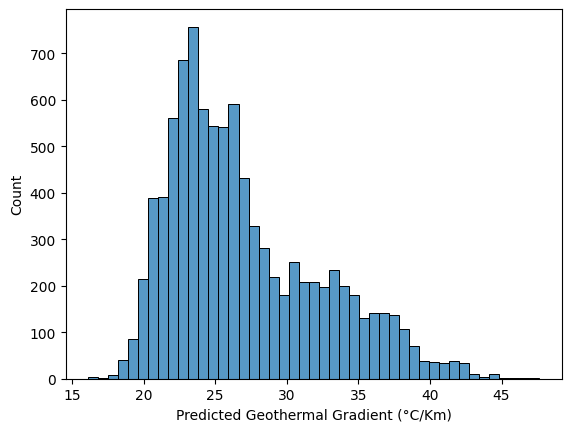

In [211]:
sns.histplot(predicted_new['Predicted Geothermal Gradient (°C/Km)'], kde=False)

### Plot map

/tmp/ipykernel_21655/2277474893.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


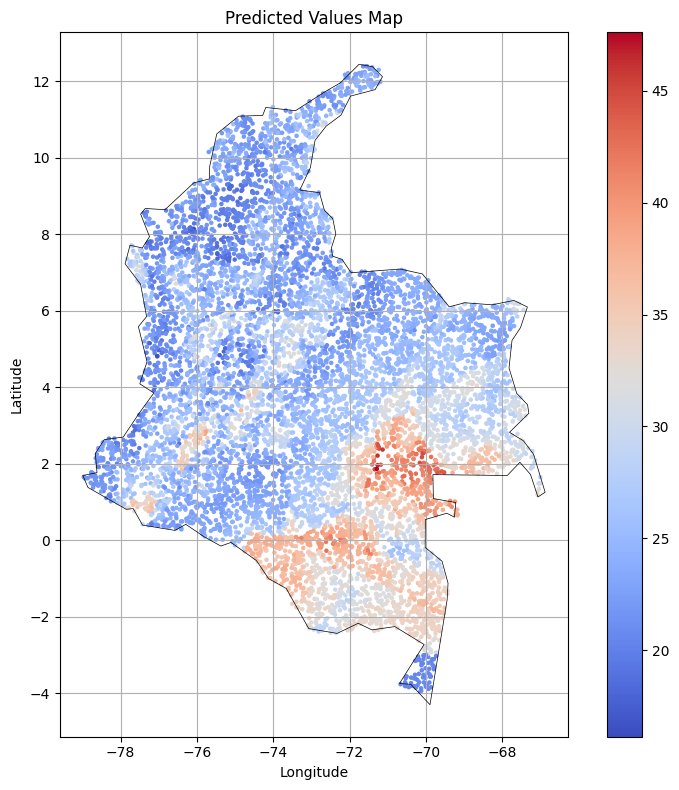

In [212]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoDataFrame for predicted values
predicted_gdf = gpd.GeoDataFrame(predicted_new, geometry=gpd.points_from_xy(predicted_new['Longitude'], predicted_new['Latitude']))

# Determine the color range
vmin = predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].min()
vmax = predicted_gdf['Predicted Geothermal Gradient (°C/Km)'].max()

# Create a subplot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the predicted values
predicted_plot = predicted_gdf.plot(column='Predicted Geothermal Gradient (°C/Km)', cmap='coolwarm', markersize=5, legend=True, ax=ax)
ax.set_title('Predicted Values Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Calculate grid positions based on your data's latitude and longitude
min_lon, max_lon = -78, -66
min_lat, max_lat = -4, 12
lon_grid = list(range(int(min_lon), int(max_lon) + 1, 2))
lat_grid = list(range(int(min_lat), int(max_lat) + 1, 2))

# Add gridlines for latitude and longitude
ax.set_xticks(lon_grid)
ax.set_yticks(lat_grid)
ax.grid()

# Load world country geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Subset the world dataset to only include countries within your area of interest
world = world.cx[-74:-73, 4:5]

# Plot country borders within your area of interest
world.boundary.plot(ax=ax, linewidth=0.5, color='black')

# Show the plot
plt.tight_layout()
plt.show()